<a href="https://colab.research.google.com/github/juli-ter/Coursework4/blob/main/Favorita_Grocery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import datetime
# Utilities
# from viz_utils import *
# from custom_transformers import *
# from ml_utils import *

# DataPrep
# import re
# from nltk.corpus import stopwords
# from nltk.stem import RSLPStemmer
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
# import joblib

# # Modeling
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
# import lightgbm as lgb

In [3]:

raw_path = '/content/drive/MyDrive/Marketing/favorita_data/'
# holidays = pd.read_csv(raw_path + 'holidays_events.csv', index_col=False)
# oil = pd.read_csv(raw_path + 'oil.csv', index_col=False)
# stores = pd.read_csv(raw_path + 'stores.csv', index_col=False)
# train = pd.read_csv(raw_path + 'train.csv', index_col=False)


In [ ]:
# train = pd.read_csv(raw_path + 'train.csv', nrows=100000)


### Memory managing

Train dataset is so big, it crashes everything

Let's look at test and see what changes we can make

#### test memory overview

In [ ]:
test = pd.read_csv(raw_path + 'test.csv')


In [ ]:
mem_test = test.memory_usage(index=True).sum()
print("test dataset uses ", mem_test/ 1024**2," MB")
test.head()

test dataset uses  106.07284545898438  MB


,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [ ]:
print(test.max())
print(test.min())
print(test.dtypes)

id              128867503
date           2017-08-31
store_nbr              54
item_nbr          2134244
onpromotion          True
dtype: object
id              125497040
date           2017-08-16
store_nbr               1
item_nbr            96995
onpromotion         False
dtype: object
id              int64
date           object
store_nbr       int64
item_nbr        int64
onpromotion      bool
dtype: object


In [ ]:
#There are only 54 stores
test['store_nbr'] = test['store_nbr'].astype(np.uint8)

# The ID column is a continuous number from 1 to 128867502 in train and 128867503 to 125497040 in test
test['id'] = test['id'].astype(np.uint32)

# item number is unsigned 
test['item_nbr'] = test['item_nbr'].astype(np.uint32)

#Converting the date column to date format
test['date'] = pd.to_datetime(test['date'],format="%Y-%m-%d")

#check memory
print(test.memory_usage(index=True))
new_mem_test = test.memory_usage(index=True).sum()
print("test dataset uses ", new_mem_test / 1024**2," MB after changes")
print("memory saved =", (mem_test - new_mem_test)/ 1024**2," MB")

Index               128
id             13481856
date           26963712
store_nbr       3370464
item_nbr       13481856
onpromotion     3370464
dtype: int64
test dataset uses  57.85797119140625  MB after changes
memory saved = 48.214874267578125  MB


Around 50% save in memory utilization

In [ ]:
print(test.memory_usage())

#check range of float 16
min_value = np.finfo(np.float16).min
max_value = np.finfo(np.float16).max
print("range of float16 is", min_value, max_value)

Index               128
id             13481856
date           26963712
store_nbr       3370464
item_nbr       13481856
onpromotion     3370464
dtype: int64
range of float16 is -65500.0 65500.0


In [ ]:
del(test)


#### to train

In [4]:
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32
           }
items = pd.read_csv(raw_path + 'items.csv', dtype = dtype_dict, index_col=False)


In [ ]:
125497040 /3 

41832346.666666664

In [ ]:
train_part1 = pd.read_csv(raw_path + 'train.csv', dtype = dtype_dict, nrows=41832347)
mem_train = train_part1.memory_usage(index=True).sum()
print("train1 dataset uses ", mem_train / 1024**2," MB ")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


train1 dataset uses  1156.9387350082397  MB 


In [ ]:
train_part1['Year'] = pd.DatetimeIndex(train_part1['date']).year
train_part1['Month'] = pd.DatetimeIndex(train_part1['date']).month
train_part1['Day'] = pd.DatetimeIndex(train_part1['date']).day.astype(np.uint8)
del(train_part1['date'])
train_part1['Day']=train_part1['Day'].astype(np.uint8)
train_part1['Month']=train_part1['Month'].astype(np.uint8)
train_part1['Year']=train_part1['Year'].astype(np.uint16)

#impute the missing values to be -1
train_part1["onpromotion"].fillna(0, inplace=True)
train_part1["onpromotion"]=train_part1["onpromotion"].astype(np.int8)

mem_train = train_part1.memory_usage(index=True).sum()
print("train1 dataset uses ", mem_train / 1024**2," MB ")

train1 dataset uses  718.0999507904053  MB 


In [ ]:
# train_part1 = pd.read_csv(raw_path + 'train.csv', dtype = dtype_dict, usecols=[0,2,3,4])
# print(train_part1.dtypes)

id             uint32
store_nbr       uint8
item_nbr       uint32
unit_sales    float32
dtype: object


In [ ]:
train_part1

,id,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day
0,0,25,103665,7.0,0,2013,1,1
1,1,25,105574,1.0,0,2013,1,1
2,2,25,105575,2.0,0,2013,1,1
3,3,25,108079,1.0,0,2013,1,1
4,4,25,108701,1.0,0,2013,1,1
...,...,...,...,...,...,...,...,...
41832342,41832342,36,1239820,5.0,0,2015,2,25
41832343,41832343,36,1239840,2.0,0,2015,2,25
41832344,41832344,36,1239841,7.0,0,2015,2,25
41832345,41832345,36,1239842,8.0,0,2015,2,25


In [ ]:
colnames=['id', 'date', 'store_nbr',	'item_nbr',	'unit_sales',	'onpromotion'] 
train_part2 = pd.read_csv(raw_path + 'train.csv', dtype = dtype_dict, names=colnames, skiprows=41832347, nrows=41832347)
mem_train = train_part2.memory_usage(index=True).sum()
print("train2 dataset uses ", mem_train / 1024**2," MB ")


train2 dataset uses  877.6776905059814  MB 


In [ ]:
train_part2['Year'] = pd.DatetimeIndex(train_part2['date']).year
train_part2['Month'] = pd.DatetimeIndex(train_part2['date']).month
train_part2['Day'] =pd.DatetimeIndex(train_part2['date']).day.astype(np.uint8)
del(train_part2['date'])
train_part2['Day']=train_part2['Day'].astype(np.uint8)
train_part2['Month']=train_part2['Month'].astype(np.uint8)
train_part2['Year']=train_part2['Year'].astype(np.uint16)

#impute the missing values to be -1
train_part2["onpromotion"].fillna(0, inplace=True)
train_part2["onpromotion"]=train_part2["onpromotion"].astype(np.int8)

mem_train = train_part2.memory_usage(index=True).sum()
print("train2 dataset uses ", mem_train / 1024**2," MB ")

train2 dataset uses  718.0999507904053  MB 


In [ ]:
train_part2

In [ ]:
41832346*2+1

83664693

In [ ]:
colnames=['id', 'date', 'store_nbr',	'item_nbr',	'unit_sales',	'onpromotion'] 
train_part3 = pd.read_csv(raw_path + 'train.csv', dtype = dtype_dict, names=colnames, skiprows=83664693)
mem_train = train_part3.memory_usage(index=True).sum()
print("train3 dataset uses ", mem_train / 1024**2," MB ")


train3 dataset uses  877.6777114868164  MB 


In [ ]:
train_part3['Year'] = pd.DatetimeIndex(train_part3['date']).year
train_part3['Month'] = pd.DatetimeIndex(train_part3['date']).month
train_part3['Day'] =pd.DatetimeIndex(train_part3['date']).day.astype(np.uint8)
del(train_part3['date'])
train_part3['Day']=train_part3['Day'].astype(np.uint8)
train_part3['Month']=train_part3['Month'].astype(np.uint8)
train_part3['Year']=train_part3['Year'].astype(np.uint16)

#impute the missing values to be -1
train_part3["onpromotion"].fillna(0, inplace=True)
train_part3["onpromotion"]=train_part3["onpromotion"].astype(np.int8)

mem_train = train_part3.memory_usage(index=True).sum()
print("train3 dataset uses ", mem_train / 1024**2," MB ")

train2 dataset uses  718.099967956543  MB 


In [ ]:
train_part3

,id,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day
0,83664692,4,559872,9.0,0,2016,7,1
1,83664693,4,559873,9.0,0,2016,7,1
2,83664694,4,562568,4.0,1,2016,7,1
3,83664695,4,563654,1.0,0,2016,7,1
4,83664696,4,564110,3.0,0,2016,7,1
...,...,...,...,...,...,...,...,...
41832343,125497035,54,2089339,4.0,0,2017,8,15
41832344,125497036,54,2106464,1.0,1,2017,8,15
41832345,125497037,54,2110456,192.0,0,2017,8,15
41832346,125497038,54,2113914,198.0,1,2017,8,15


###previous

In [ ]:
mem_train = train_part1.memory_usage(index=True).sum()
print("train1 dataset uses ", mem_train / 1024**2," MB ")

train1 dataset uses  1555.883071899414  MB 


In [ ]:
train_part2 = pd.read_csv(raw_path + 'train.csv', dtype=dtype_dict, usecols=[1,5],parse_dates=[0])
train_part2['Year'] = pd.DatetimeIndex(train_part2['date']).year
train_part2['Month'] = pd.DatetimeIndex(train_part2['date']).month
train_part2['Day'] =pd.DatetimeIndex(train_part2['date']).day.astype(np.uint8)
del(train_part2['date'])
train_part2['Day']=train_part2['Day'].astype(np.uint8)
train_part2['Month']=train_part2['Month'].astype(np.uint8)
train_part2['Year']=train_part2['Year'].astype(np.uint16)

#impute the missing values to be -1
train_part2["onpromotion"].fillna(0, inplace=True)
train_part2["onpromotion"]=train_part2["onpromotion"].astype(np.int8)
print(train_part2.head())
print(train_part2.dtypes)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


   onpromotion  Year  Month  Day
0            0  2013      1    1
1            0  2013      1    1
2            0  2013      1    1
3            0  2013      1    1
4            0  2013      1    1
onpromotion      int8
Year           uint16
Month           uint8
Day             uint8
dtype: object


In [ ]:
mem_train = train_part2.memory_usage(index=True).sum()
print("train2 dataset uses ", mem_train / 1024**2," MB ")

train2 dataset uses  598.4166412353516  MB 


In [ ]:
train = pd.concat([train_part1.reset_index(drop=True), train_part2], axis=1)
#drop temp files
del(train_part1)
del(train_part2)
#Further Id is just an indicator column, hence not required for analysis
id = train['id']
del(train['id'])
# check memory
print(train.memory_usage())
#The extracted train.csv file is approx 5 GB
mem_train=5*1024**3
new_mem_train=train.memory_usage().sum()
print("Train dataset uses ",new_mem_train/ 1024**2," MB after changes")
print("memory saved is approx",(mem_train-new_mem_train)/ 1024**2," MB")

Index                128
store_nbr      125497040
item_nbr       501988160
unit_sales     501988160
onpromotion    125497040
Year           250994080
Month          125497040
Day            125497040
dtype: int64
Train dataset uses  1675.5663757324219  MB after changes
memory saved is approx 3444.433624267578  MB


### EDA

In [ ]:
top10_families = ['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY', 'BREAD/BAKERY', 'POULTRY', 'MEATS', 'PERSONAL CARE', 'DELI']

In [ ]:
top3_families = ['GROCERY I', 'BEVERAGES', 'PRODUCE']

In [ ]:
items_top = items[items['family'].isin(top3_families)]

In [ ]:
# items_top = items_top.drop(['class'], axis = 1, inplace = True)
items_top

,item_nbr,family,perishable
0,96995,GROCERY I,0
1,99197,GROCERY I,0
3,103520,GROCERY I,0
5,105574,GROCERY I,0
6,105575,GROCERY I,0
...,...,...,...
4094,2132163,GROCERY I,0
4095,2132318,GROCERY I,0
4096,2132945,GROCERY I,0
4097,2132957,GROCERY I,0


In [ ]:
un_items = items_top.item_nbr.unique()
un_items

array([  96995,   99197,  103520, ..., 2132945, 2132957, 2134058],
      dtype=uint32)

In [ ]:
m_items = items_top.merge(train_part1, on='item_nbr', how='inner')
# mf = olist_marketing.merge(olist_closed_deals, on='mql_id', how='left')
m_items

,item_nbr,family,perishable,id,store_nbr,unit_sales,onpromotion,Year,Month,Day
0,96995,GROCERY I,0,196657,44,1.0,0,2013,1,6
1,96995,GROCERY I,0,207764,2,2.0,0,2013,1,7
2,96995,GROCERY I,0,236538,44,1.0,0,2013,1,7
3,96995,GROCERY I,0,275800,44,1.0,0,2013,1,8
4,96995,GROCERY I,0,282601,50,2.0,0,2013,1,8
...,...,...,...,...,...,...,...,...,...,...
22390628,1906100,PRODUCE,1,38577787,44,21.0,1,2014,12,31
22390629,1906100,PRODUCE,1,38579825,45,7.0,1,2014,12,31
22390630,1906100,PRODUCE,1,38587851,49,7.0,1,2014,12,31
22390631,1906100,PRODUCE,1,38589712,50,2.0,1,2014,12,31


In [ ]:
out = '/content/drive/MyDrive/Marketing/favorita_data/'
m_items.to_csv(out + "m_items1.csv", index=False)

In [ ]:
del(train_part1)

In [ ]:
m_items2 = items_top.merge(train_part2, on='item_nbr', how='inner')
# mf = olist_marketing.merge(olist_closed_deals, on='mql_id', how='left')
m_items2

,item_nbr,family,class,perishable,id,store_nbr,unit_sales,onpromotion,Year,Month,Day
0,99197,GROCERY I,1067,0,43529814,8,1.0,0,2015,3,25
1,99197,GROCERY I,1067,0,43565168,44,4.0,0,2015,3,25
2,99197,GROCERY I,1067,0,43573392,49,10.0,0,2015,3,25
3,99197,GROCERY I,1067,0,43582622,3,5.0,0,2015,3,26
4,99197,GROCERY I,1067,0,43586794,6,1.0,0,2015,3,26
...,...,...,...,...,...,...,...,...,...,...,...
23633903,2037487,PRODUCE,2006,1,83645385,47,5.0,0,2016,6,30
23633904,2037487,PRODUCE,2006,1,83647627,48,2.0,0,2016,6,30
23633905,2037487,PRODUCE,2006,1,83659407,1,2.0,0,2016,7,1
23633906,2037487,PRODUCE,2006,1,83661642,2,18.0,0,2016,7,1


In [ ]:
out = '/content/drive/MyDrive/Marketing/favorita_data/'
m_items2.to_csv(out + "m_items2.csv", index=False)

In [ ]:
del(train_part2)

In [ ]:
m_items3 = items_top.merge(train_part3, on='item_nbr', how='inner')
# mf = olist_marketing.merge(olist_closed_deals, on='mql_id', how='left')
m_items3

,item_nbr,family,class,perishable,id,store_nbr,unit_sales,onpromotion,Year,Month,Day
0,96995,GROCERY I,1093,0,110480440,47,3.0,0,2017,3,26
1,96995,GROCERY I,1093,0,110550229,29,1.0,0,2017,3,27
2,96995,GROCERY I,1093,0,110584213,47,2.0,0,2017,3,27
3,96995,GROCERY I,1093,0,110586911,48,1.0,0,2017,3,27
4,96995,GROCERY I,1093,0,110684218,47,3.0,0,2017,3,28
...,...,...,...,...,...,...,...,...,...,...,...
24325211,2127114,BEVERAGES,1152,0,125441387,26,2.0,0,2017,8,15
24325212,2127114,BEVERAGES,1152,0,125473876,44,2.0,0,2017,8,15
24325213,2127114,BEVERAGES,1152,0,125476601,45,5.0,0,2017,8,15
24325214,2127114,BEVERAGES,1152,0,125484286,48,6.0,0,2017,8,15


In [ ]:
m_items3.to_csv(out + "m_items3.csv", index=False)

In [ ]:
del(train_part3)

#### concating

In [4]:

dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32,
            "Year":np.uint16,
            "Month":np.uint8,
            "Day":np.uint8,
           }

In [ ]:
train1 = pd.read_csv(raw_path + 'm_items1.csv', dtype = dtype_dict, index_col=False)
train2 = pd.read_csv(raw_path + 'm_items2.csv', dtype = dtype_dict, index_col=False)
train3 = pd.read_csv(raw_path + 'm_items3.csv', dtype = dtype_dict, index_col=False)


In [ ]:
train12 = train1.append(train2, ignore_index=True)

In [ ]:
del(train1)
del(train2)

In [ ]:
train = train12.append(train3, ignore_index=True)

In [ ]:
del(train12)
del(train3)

In [ ]:
train = train.drop(columns=['class'])
train

,item_nbr,family,perishable,id,store_nbr,unit_sales,onpromotion,Year,Month,Day
0,96995,GROCERY I,0,196657,44,1.0,0,2013,1,6
1,96995,GROCERY I,0,207764,2,2.0,0,2013,1,7
2,96995,GROCERY I,0,236538,44,1.0,0,2013,1,7
3,96995,GROCERY I,0,275800,44,1.0,0,2013,1,8
4,96995,GROCERY I,0,282601,50,2.0,0,2013,1,8
...,...,...,...,...,...,...,...,...,...,...
70349752,2127114,BEVERAGES,0,125441387,26,2.0,0,2017,8,15
70349753,2127114,BEVERAGES,0,125473876,44,2.0,0,2017,8,15
70349754,2127114,BEVERAGES,0,125476601,45,5.0,0,2017,8,15
70349755,2127114,BEVERAGES,0,125484286,48,6.0,0,2017,8,15


In [ ]:
mem_train = train.memory_usage(index=True).sum()
print("train final dataset uses ", mem_train / 1024**2," MB ")

train final dataset uses  2750.7211351394653  MB 


In [ ]:
out = '/content/drive/MyDrive/Marketing/favorita_data/'
train.to_csv(out + "train_items.csv", index=False)

#### train concat

In [ ]:

dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32,
            "Year":np.uint16,
            "Month":np.uint8,
            "Day":np.uint8,
           }

In [ ]:
stores = pd.read_csv(raw_path + 'stores.csv', dtype = dtype_dict, usecols=[0,3], index_col=False)
stores

In [ ]:
# train = pd.read_csv(raw_path + 'train_items.csv', dtype = dtype_dict, index_col=False)


In [ ]:
grocery_df = train[train['family']== 'GROCERY I']
grocery_df

,item_nbr,family,perishable,id,store_nbr,unit_sales,onpromotion,Year,Month,Day
0,96995,GROCERY I,0,196657,44,1.0,0,2013,1,6
1,96995,GROCERY I,0,207764,2,2.0,0,2013,1,7
2,96995,GROCERY I,0,236538,44,1.0,0,2013,1,7
3,96995,GROCERY I,0,275800,44,1.0,0,2013,1,8
4,96995,GROCERY I,0,282601,50,2.0,0,2013,1,8
...,...,...,...,...,...,...,...,...,...,...
70349500,2126842,GROCERY I,0,125287925,52,3.0,0,2017,8,13
70349501,2126842,GROCERY I,0,125314778,11,1.0,0,2017,8,14
70349502,2126842,GROCERY I,0,125325328,18,1.0,0,2017,8,14
70349503,2126842,GROCERY I,0,125417351,11,1.0,0,2017,8,15


In [ ]:
grocery_df.to_csv(out + "grocery_df.csv", index=False)

In [24]:
out = '/content/drive/MyDrive/Marketing/favorita_data/'


In [ ]:
grocery_df = pd.read_csv(raw_path + 'grocery_df.csv', dtype = dtype_dict, index_col=False)
grocery_df = grocery_df.drop(columns=['family'])
grocery_df

In [ ]:
mem_train = grocery_df.memory_usage(index=True).sum()
print("grocery_df dataset uses ", mem_train / 1024**2," MB ")

grocery_df dataset uses  1435.972505569458  MB 


In [ ]:
grocery_all = grocery_df.merge(stores, on = 'store_nbr') 

In [ ]:
grocery_all.to_csv(out + "grocery_all.csv", index=False)

In [ ]:
grocery_all

,item_nbr,perishable,id,store_nbr,unit_sales,onpromotion,Year,Month,Day,type
0,96995,0,196657,44,1.0,0,2013,1,6,A
1,96995,0,236538,44,1.0,0,2013,1,7,A
2,96995,0,275800,44,1.0,0,2013,1,8,A
3,96995,0,314674,44,1.0,0,2013,1,9,A
4,96995,0,353302,44,1.0,0,2013,1,10,A
...,...,...,...,...,...,...,...,...,...,...
45628061,2123775,0,125181964,52,3.0,0,2017,8,12,A
45628062,2123775,0,125391119,52,1.0,0,2017,8,14,A
45628063,2123791,0,125391120,52,1.0,0,2017,8,14,A
45628064,2126842,0,125077000,52,1.0,0,2017,8,11,A


####get only grocery1

In [4]:

dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32,
            "Year":np.uint16,
            "Month":np.uint8,
            "Day":np.uint8,
           }

In [5]:
grocery = pd.read_csv(raw_path + 'grocery_all.csv', dtype = dtype_dict, index_col=False)
grocery

,item_nbr,id,store_nbr,unit_sales,onpromotion,Year,Month,Day,type
0,96995,196657,44,1.0,0,2013,1,6,A
1,96995,236538,44,1.0,0,2013,1,7,A
2,96995,275800,44,1.0,0,2013,1,8,A
3,96995,314674,44,1.0,0,2013,1,9,A
4,96995,353302,44,1.0,0,2013,1,10,A
...,...,...,...,...,...,...,...,...,...
45628061,2123775,125181964,52,3.0,0,2017,8,12,A
45628062,2123775,125391119,52,1.0,0,2017,8,14,A
45628063,2123791,125391120,52,1.0,0,2017,8,14,A
45628064,2126842,125077000,52,1.0,0,2017,8,11,A


In [7]:
grocery.rename(columns={'Year': 'year', 'Month': 'month', 'Day': 'day'}, inplace=True)


#####For every year:

In [44]:
df13 = grocery.loc[grocery['year'] == 2017]
df13

,item_nbr,id,store_nbr,unit_sales,onpromotion,year,month,day,type
835450,96995,110982546,44,1.0,0,2017,3,31,A
835451,96995,111098665,44,1.0,0,2017,4,1,A
835452,96995,111946045,44,2.0,0,2017,4,9,A
835453,96995,112049784,44,2.0,0,2017,4,10,A
835454,96995,112150949,44,1.0,0,2017,4,11,A
...,...,...,...,...,...,...,...,...,...
45628061,2123775,125181964,52,3.0,0,2017,8,12,A
45628062,2123775,125391119,52,1.0,0,2017,8,14,A
45628063,2123791,125391120,52,1.0,0,2017,8,14,A
45628064,2126842,125077000,52,1.0,0,2017,8,11,A


In [45]:
df13['full_date'] = pd.to_datetime(df13[['year', 'month', 'day']])
df13

<ipython-input-45-efdf7fff49a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df13['full_date'] = pd.to_datetime(df13[['year', 'month', 'day']])


,item_nbr,id,store_nbr,unit_sales,onpromotion,year,month,day,type,full_date
835450,96995,110982546,44,1.0,0,2017,3,31,A,2017-03-31
835451,96995,111098665,44,1.0,0,2017,4,1,A,2017-04-01
835452,96995,111946045,44,2.0,0,2017,4,9,A,2017-04-09
835453,96995,112049784,44,2.0,0,2017,4,10,A,2017-04-10
835454,96995,112150949,44,1.0,0,2017,4,11,A,2017-04-11
...,...,...,...,...,...,...,...,...,...,...
45628061,2123775,125181964,52,3.0,0,2017,8,12,A,2017-08-12
45628062,2123775,125391119,52,1.0,0,2017,8,14,A,2017-08-14
45628063,2123791,125391120,52,1.0,0,2017,8,14,A,2017-08-14
45628064,2126842,125077000,52,1.0,0,2017,8,11,A,2017-08-11


In [46]:
df13['weekday'] = df13['full_date'].dt.dayofweek
df13['week_num'] = df13['full_date'].dt.isocalendar().week
df13

<ipython-input-46-338e5770ebb6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df13['weekday'] = df13['full_date'].dt.dayofweek
<ipython-input-46-338e5770ebb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df13['week_num'] = df13['full_date'].dt.isocalendar().week


,item_nbr,id,store_nbr,unit_sales,onpromotion,year,month,day,type,full_date,weekday,week_num
835450,96995,110982546,44,1.0,0,2017,3,31,A,2017-03-31,4,13
835451,96995,111098665,44,1.0,0,2017,4,1,A,2017-04-01,5,13
835452,96995,111946045,44,2.0,0,2017,4,9,A,2017-04-09,6,14
835453,96995,112049784,44,2.0,0,2017,4,10,A,2017-04-10,0,15
835454,96995,112150949,44,1.0,0,2017,4,11,A,2017-04-11,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...
45628061,2123775,125181964,52,3.0,0,2017,8,12,A,2017-08-12,5,32
45628062,2123775,125391119,52,1.0,0,2017,8,14,A,2017-08-14,0,33
45628063,2123791,125391120,52,1.0,0,2017,8,14,A,2017-08-14,0,33
45628064,2126842,125077000,52,1.0,0,2017,8,11,A,2017-08-11,4,32


In [47]:
df13['weekday']=df13['weekday'].astype(np.uint8)
df13['week_num']=df13['week_num'].astype(np.uint8)

<ipython-input-47-a78d8cfbda38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df13['weekday']=df13['weekday'].astype(np.uint8)
<ipython-input-47-a78d8cfbda38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df13['week_num']=df13['week_num'].astype(np.uint8)


In [48]:
mem_test = df13.memory_usage(index=True).sum()
print("df13 dataset uses ", mem_test/ 1024**2," MB")

df13 dataset uses  401.1696081161499  MB


In [49]:
df13.to_csv(out + "df17.csv", index=False)

In [ ]:
# grocery.perishable.unique()


array([0])

In [ ]:
# grocery = grocery.drop(columns=['perishable'])
# grocery

,item_nbr,id,store_nbr,unit_sales,onpromotion,Year,Month,Day,type
0,96995,196657,44,1.0,0,2013,1,6,A
1,96995,236538,44,1.0,0,2013,1,7,A
2,96995,275800,44,1.0,0,2013,1,8,A
3,96995,314674,44,1.0,0,2013,1,9,A
4,96995,353302,44,1.0,0,2013,1,10,A
...,...,...,...,...,...,...,...,...,...
45628061,2123775,125181964,52,3.0,0,2017,8,12,A
45628062,2123775,125391119,52,1.0,0,2017,8,14,A
45628063,2123791,125391120,52,1.0,0,2017,8,14,A
45628064,2126842,125077000,52,1.0,0,2017,8,11,A


In [ ]:
# grocery.to_csv(out + "grocery_all.csv", index=False)

### Time analysis

In [5]:

dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32,
            "year":np.uint16,
            "month":np.uint8,
            "day":np.uint8,
            "weekday":np.uint8,
            "week_num":np.uint8,
           }

In [7]:
df13 = pd.read_csv(raw_path + 'df13.csv', dtype = dtype_dict, index_col=False)
df14 = pd.read_csv(raw_path + 'df14.csv', dtype = dtype_dict, index_col=False)
df15 = pd.read_csv(raw_path + 'df15.csv', dtype = dtype_dict, index_col=False)
df16 = pd.read_csv(raw_path + 'df16.csv', dtype = dtype_dict, index_col=False)
df17 = pd.read_csv(raw_path + 'df17.csv', dtype = dtype_dict, index_col=False)


In [9]:
df15

,item_nbr,id,store_nbr,unit_sales,onpromotion,year,month,day,type,full_date,weekday,week_num
0,103520,38641037,44,10.0,0,2015,1,2,A,2015-01-02,4,1
1,103520,38702588,44,8.0,0,2015,1,3,A,2015-01-03,5,1
2,103520,38763703,44,12.0,0,2015,1,4,A,2015-01-04,6,1
3,103520,38823534,44,5.0,0,2015,1,5,A,2015-01-05,0,2
4,103520,38881392,44,3.0,0,2015,1,6,A,2015-01-06,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
10088648,2027252,66016740,22,11.0,0,2015,12,27,C,2015-12-27,6,52
10088649,2027252,66111882,22,6.0,0,2015,12,28,C,2015-12-28,0,53
10088650,2027252,66205987,22,3.0,0,2015,12,29,C,2015-12-29,1,53
10088651,2027252,66303051,22,2.0,0,2015,12,30,C,2015-12-30,2,53


In [29]:
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.values())
colors[0]

'#1f77b4'

Weekdays

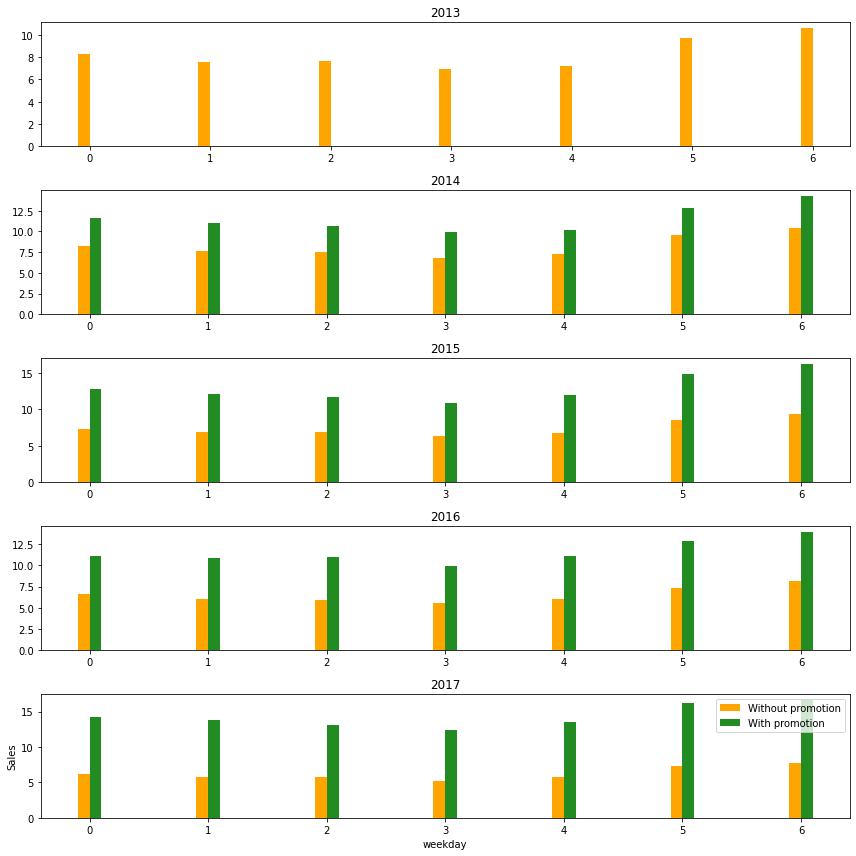

In [73]:
labels = [0, 1, 2, 3, 4, 5, 6]
years = [df13, df14, df15, df16, df17]
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

figure, axis = plt.subplots(5, 1, figsize=(12, 12))
for y in range(0, len(years)): 
    # df_name = 'df'+str(years[y])[2:]
    num = 0    
    rects2 = axis[y].bar(x - width/2, [years[y][(years[y]['weekday'] == i) & (years[y]['onpromotion'] == 0)].unit_sales.mean() for i in labels], color = "orange", width=width, label='Without promotion')
    rects4 = axis[y].bar(x + width/2, [years[y][(years[y]['weekday'] == i) & (years[y]['onpromotion'] == 1)].unit_sales.mean() for i in labels], color = "forestgreen", width=width, label='With promotion')
    num+=1
    axis[y].set_title("20" + str(13+y))
plt.xticks(x, labels)
plt.xlabel("weekday")
plt.ylabel("Sales")
plt.legend(fontsize = 10)
plt.tight_layout()

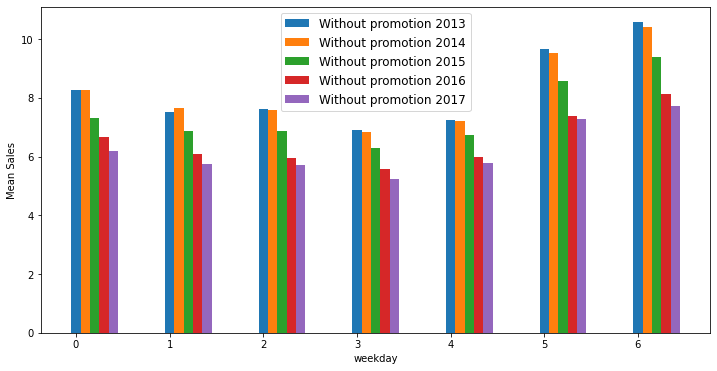

In [69]:
fig, ax = plt.subplots(figsize = [12, 6])
for y in range(0, len(years)): 
    # df_name = 'df'+str(years[y])[2:]
    num = 0    
    rects2 = ax.bar(x + (5*y)*(width/5), [years[y][(years[y]['weekday'] == i) & (years[y]['onpromotion'] == 0)].unit_sales.mean() for i in labels], color = colors[y], width=width, label='Without promotion 20' +str(13+y) )
    # rects4 = ax.bar(x + width/2, [years[y][(years[y]['weekday'] == i) & (years[y]['onpromotion'] == 1)].unit_sales.mean() for i in labels], color = "forestgreen", width=width, label='With promotion')
    num+=1

plt.xticks(x, labels)
plt.xlabel("weekday")
plt.ylabel("Mean Sales")
plt.legend(fontsize = 12)

On average on Sundays customers buy more, but with years less products without promo

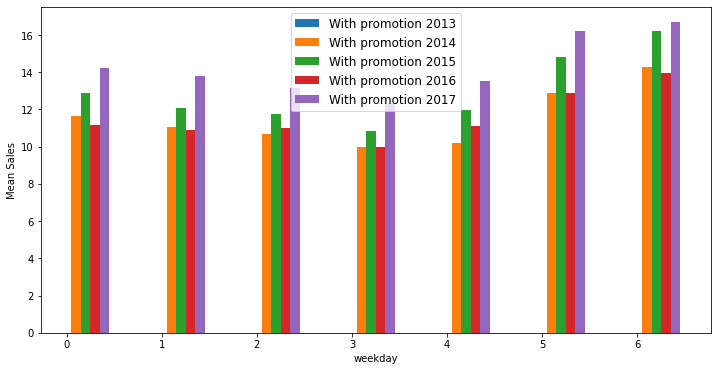

In [70]:
fig, ax = plt.subplots(figsize = [12, 6])
for y in range(0, len(years)): 
    # df_name = 'df'+str(years[y])[2:]
    num = 0    
    rects2 = ax.bar(x + (5*y)*(width/5), [years[y][(years[y]['weekday'] == i) & (years[y]['onpromotion'] == 1)].unit_sales.mean() for i in labels], color = colors[y], width=width, label='With promotion 20' +str(13+y) )
    # rects4 = ax.bar(x + width/2, [years[y][(years[y]['weekday'] == i) & (years[y]['onpromotion'] == 1)].unit_sales.mean() for i in labels], color = "forestgreen", width=width, label='With promotion')
    num+=1

plt.xticks(x, labels)
plt.xlabel("weekday")
plt.ylabel("Mean Sales")
plt.legend(fontsize = 12)

With years more and more products are bought with promos throughout the whole week

Weeks

In [77]:
weeks = [i for i in range(1,54)]

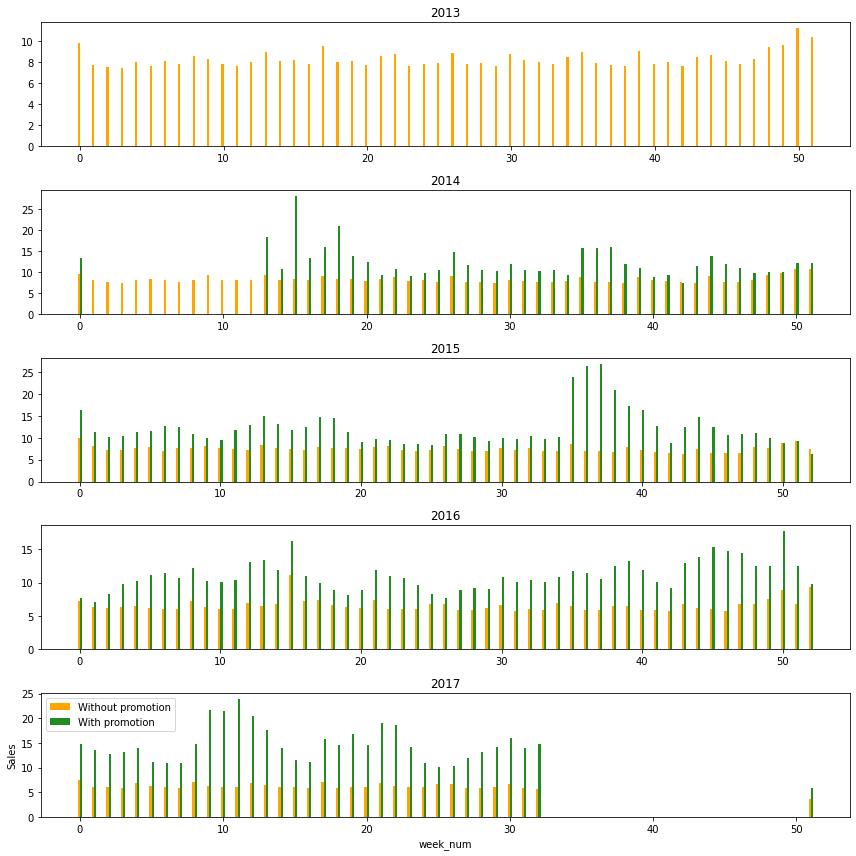

In [80]:
labels = weeks
years = [df13, df14, df15, df16, df17]
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

figure, axis = plt.subplots(5, 1, figsize=(12, 12))
for y in range(0, len(years)): 
    # df_name = 'df'+str(years[y])[2:]
    num = 0    
    rects2 = axis[y].bar(x - width/2, [years[y][(years[y]['week_num'] == i) & (years[y]['onpromotion'] == 0)].unit_sales.mean() for i in labels], color = "orange", width=width, label='Without promotion')
    rects4 = axis[y].bar(x + width/2, [years[y][(years[y]['week_num'] == i) & (years[y]['onpromotion'] == 1)].unit_sales.mean() for i in labels], color = "forestgreen", width=width, label='With promotion')
    num+=1
    axis[y].set_title("20" + str(13+y))

plt.xlabel("week_num")
plt.ylabel("Sales")
plt.legend(fontsize = 10)
plt.tight_layout()

Hard to find one pattern for all years, but we can see that around 10-13th week avg num of units sold goes up, and around september

Massive increase in sales when promos were introduced in 2014

Yearly patterns for non-promo goods are pretty consistent

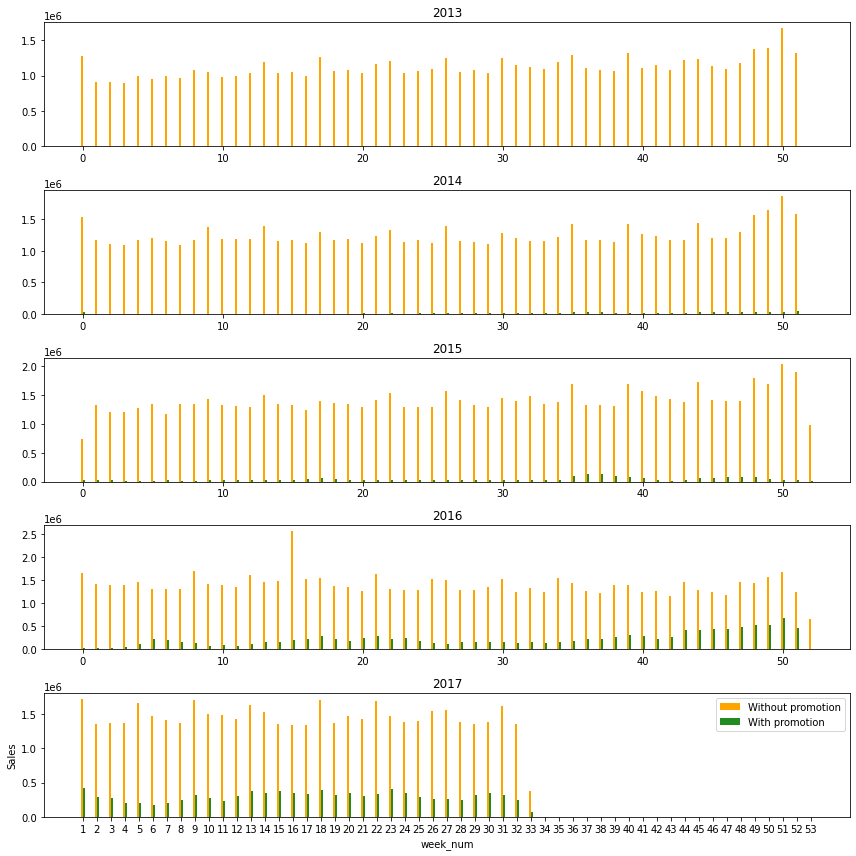

In [79]:
labels = weeks
years = [df13, df14, df15, df16, df17]
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

figure, axis = plt.subplots(5, 1, figsize=(12, 12))
for y in range(0, len(years)): 
    # df_name = 'df'+str(years[y])[2:]
    num = 0    
    rects2 = axis[y].bar(x - width/2, [years[y][(years[y]['week_num'] == i) & (years[y]['onpromotion'] == 0)].unit_sales.sum() for i in labels], color = "orange", width=width, label='Without promotion')
    rects4 = axis[y].bar(x + width/2, [years[y][(years[y]['week_num'] == i) & (years[y]['onpromotion'] == 1)].unit_sales.sum() for i in labels], color = "forestgreen", width=width, label='With promotion')
    num+=1
    axis[y].set_title("20" + str(13+y))

plt.xticks(x, labels)
plt.xlabel("week_num")
plt.ylabel("Sales")
plt.legend(fontsize = 10)
plt.tight_layout()

With years sum of sold units is increasing for promo items

% of the amount of promo goods increses every year

In [81]:
df13

,item_nbr,id,store_nbr,unit_sales,onpromotion,year,month,day,type,full_date,weekday,week_num
0,96995,196657,44,1.0,0,2013,1,6,A,2013-01-06,6,1
1,96995,236538,44,1.0,0,2013,1,7,A,2013-01-07,0,2
2,96995,275800,44,1.0,0,2013,1,8,A,2013-01-08,1,2
3,96995,314674,44,1.0,0,2013,1,9,A,2013-01-09,2,2
4,96995,353302,44,1.0,0,2013,1,10,A,2013-01-10,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
7034729,1246785,15926803,18,5.0,0,2013,12,23,B,2013-12-23,0,52
7034730,1246785,15980094,18,2.0,0,2013,12,24,B,2013-12-24,1,52
7034731,1246785,16031950,18,3.0,0,2013,12,26,B,2013-12-26,3,52
7034732,1246785,16186420,18,1.0,0,2013,12,29,B,2013-12-29,6,52


###### Transactions dinamics

In [5]:
transactions = pd.read_csv(raw_path + 'transactions.csv', index_col=False)


In [6]:
transactions.rename(columns={'date': 'full_date'}, inplace=True)


In [84]:

merged = df13.merge(transactions, on=['store_nbr', 'full_date'])
merged

,item_nbr,id,store_nbr,unit_sales,onpromotion,year,month,day,type,full_date,weekday,week_num,transactions
0,96995,196657,44,1.0,0,2013,1,6,A,2013-01-06,6,1,4925
1,103520,196658,44,11.0,0,2013,1,6,A,2013-01-06,6,1,4925
2,105574,196660,44,56.0,0,2013,1,6,A,2013-01-06,6,1,4925
3,105575,196661,44,58.0,0,2013,1,6,A,2013-01-06,6,1,4925
4,105577,196662,44,5.0,0,2013,1,6,A,2013-01-06,6,1,4925
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7033635,1158719,8205175,18,4.0,0,2013,7,12,B,2013-07-12,4,28,1205
7033636,1158720,8205176,18,5.0,0,2013,7,12,B,2013-07-12,4,28,1205
7033637,1159413,8205177,18,1.0,0,2013,7,12,B,2013-07-12,4,28,1205
7033638,1159415,8205178,18,2.0,0,2013,7,12,B,2013-07-12,4,28,1205


In [7]:
transactions

,full_date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [8]:
transactions['full_date'] = pd.to_datetime(transactions['full_date'],format="%Y-%m-%d", errors='raise')


In [9]:
gr_transactions = transactions.groupby('full_date').transactions.sum().reset_index()
gr_transactions[gr_transactions.full_date.dt.year == 2013]

,full_date,transactions
0,2013-01-01,770
1,2013-01-02,93215
2,2013-01-03,78504
3,2013-01-04,78494
4,2013-01-05,93573
...,...,...
359,2013-12-27,98330
360,2013-12-28,102858
361,2013-12-29,88729
362,2013-12-30,117645


Text(0.5, 0, 'date')

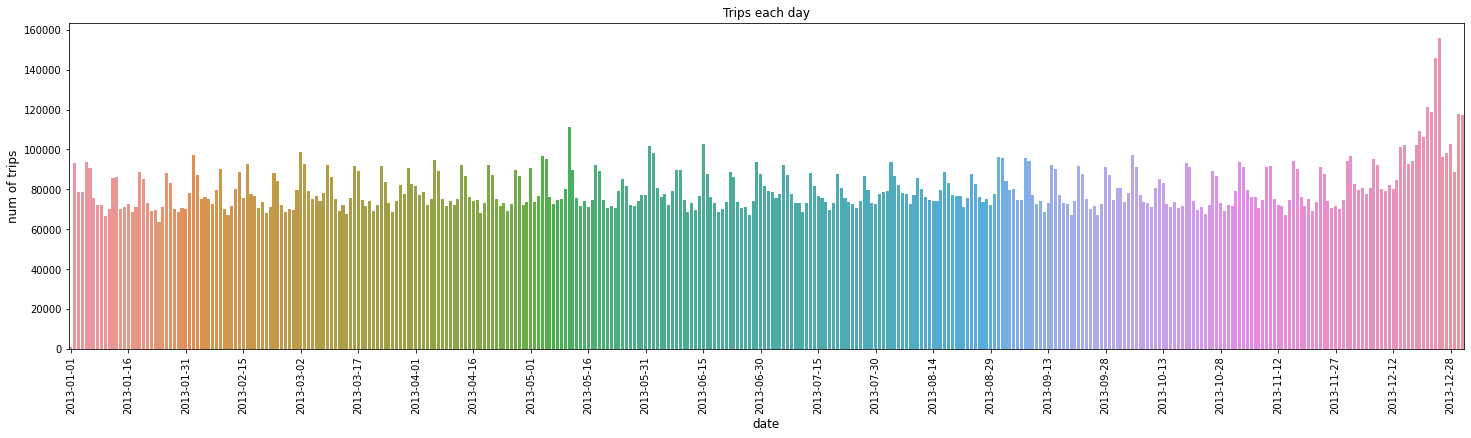

In [119]:
order = sorted(gr_transactions[gr_transactions.full_date.dt.year == 2013].full_date.dt.date.value_counts().index)
fig, ax = plt.subplots(figsize=(25,6))
# dates = gr_transactions.full_date.dt.date
graph = sns.barplot(x='full_date',y ='transactions', data=gr_transactions[gr_transactions.full_date.dt.year == 2013], order=order)

new_ticks = [i.get_text() for i in graph.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 15), new_ticks[::15], rotation=90)

plt.title('Transactions in 2013', fontsize=12)
plt.ylabel('num of trips', fontsize=12)
plt.xlabel('date', fontsize=12)

Text(0.5, 0, 'date')

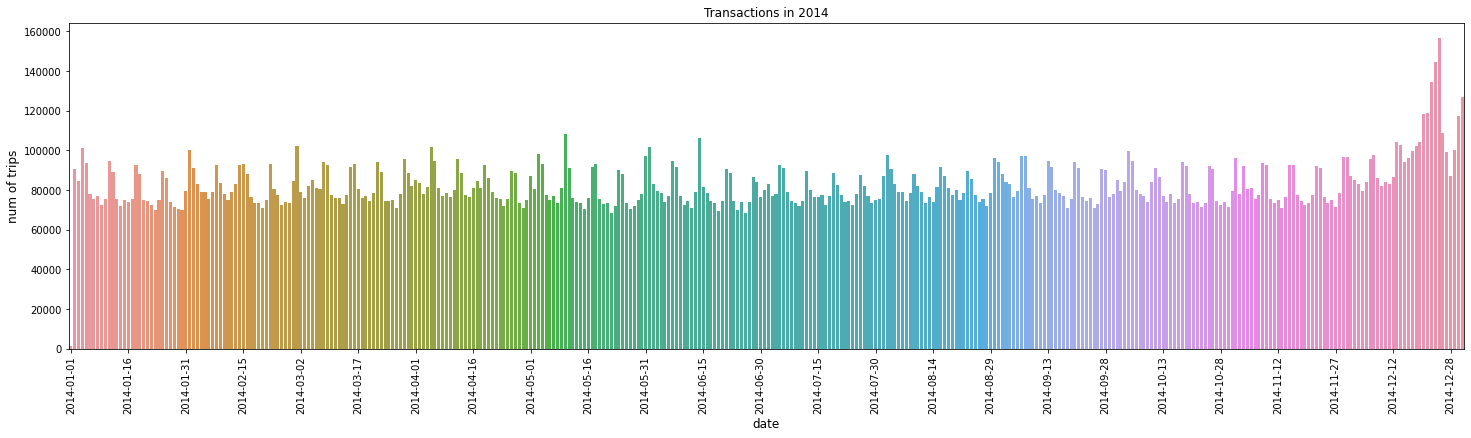

In [120]:
order = sorted(gr_transactions[gr_transactions.full_date.dt.year == 2014].full_date.dt.date.value_counts().index)
fig, ax = plt.subplots(figsize=(25,6))
# dates = gr_transactions.full_date.dt.date
graph = sns.barplot(x='full_date',y ='transactions', data=gr_transactions[gr_transactions.full_date.dt.year == 2014], order=order)

new_ticks = [i.get_text() for i in graph.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 15), new_ticks[::15], rotation=90)

plt.title('Transactions in 2014', fontsize=12)
plt.ylabel('num of trips', fontsize=12)
plt.xlabel('date', fontsize=12)

Text(0.5, 0, 'date')

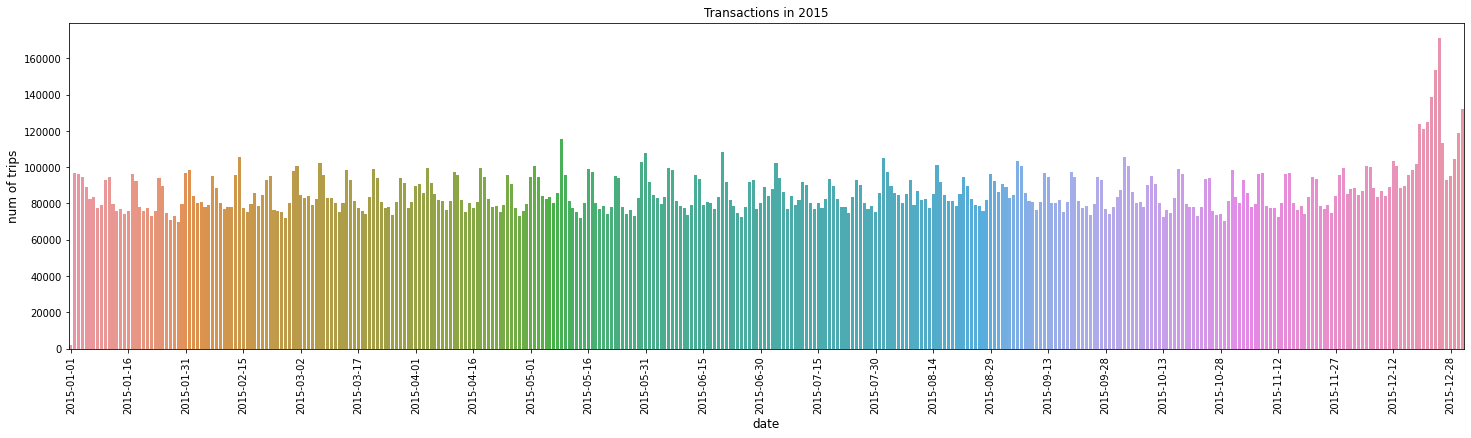

In [121]:
order = sorted(gr_transactions[gr_transactions.full_date.dt.year == 2015].full_date.dt.date.value_counts().index)
fig, ax = plt.subplots(figsize=(25,6))
# dates = gr_transactions.full_date.dt.date
graph = sns.barplot(x='full_date',y ='transactions', data=gr_transactions[gr_transactions.full_date.dt.year == 2015], order=order)

new_ticks = [i.get_text() for i in graph.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 15), new_ticks[::15], rotation=90)

plt.title('Transactions in 2015', fontsize=12)
plt.ylabel('num of trips', fontsize=12)
plt.xlabel('date', fontsize=12)

Text(0.5, 0, 'date')

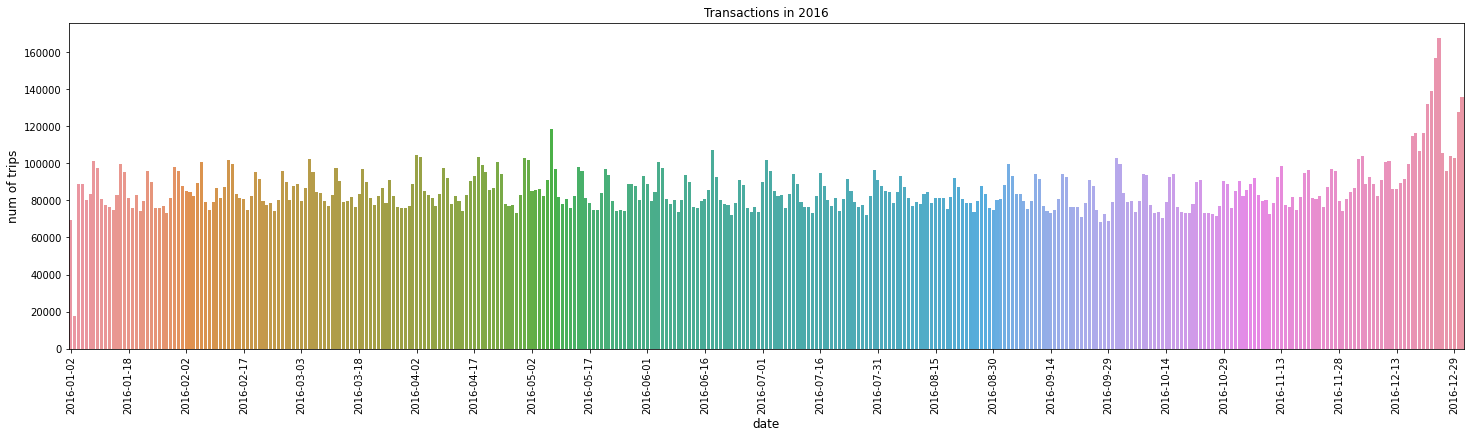

In [122]:
order = sorted(gr_transactions[gr_transactions.full_date.dt.year == 2016].full_date.dt.date.value_counts().index)
fig, ax = plt.subplots(figsize=(25,6))
# dates = gr_transactions.full_date.dt.date
graph = sns.barplot(x='full_date',y ='transactions', data=gr_transactions[gr_transactions.full_date.dt.year == 2016], order=order)

new_ticks = [i.get_text() for i in graph.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 15), new_ticks[::15], rotation=90)

plt.title('Transactions in 2016', fontsize=12)
plt.ylabel('num of trips', fontsize=12)
plt.xlabel('date', fontsize=12)

Text(0.5, 0, 'date')

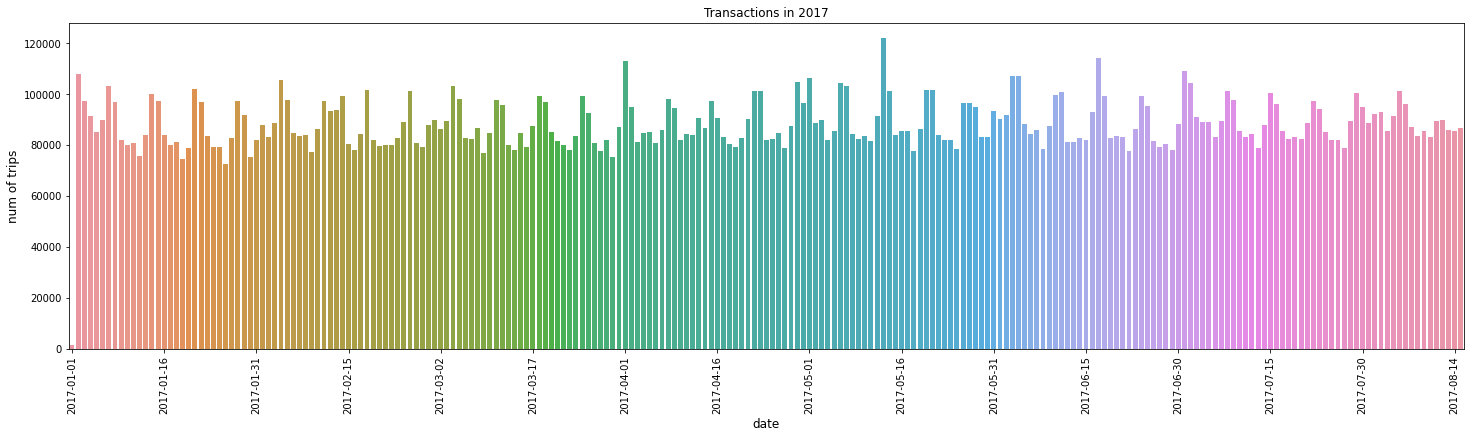

In [123]:
order = sorted(gr_transactions[gr_transactions.full_date.dt.year == 2017].full_date.dt.date.value_counts().index)
fig, ax = plt.subplots(figsize=(25,6))
# dates = gr_transactions.full_date.dt.date
graph = sns.barplot(x='full_date',y ='transactions', data=gr_transactions[gr_transactions.full_date.dt.year == 2017], order=order)

new_ticks = [i.get_text() for i in graph.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 15), new_ticks[::15], rotation=90)

plt.title('Transactions in 2017', fontsize=12)
plt.ylabel('num of trips', fontsize=12)
plt.xlabel('date', fontsize=12)

Patterns of num of transactions are very similar, huge increse in december, weekend are also higher

In [10]:
piv_tr = transactions.groupby(['store_nbr','full_date']).transactions.sum().reset_index()
piv_tr

,store_nbr,full_date,transactions
0,1,2013-01-02,2111
1,1,2013-01-03,1833
2,1,2013-01-04,1863
3,1,2013-01-05,1509
4,1,2013-01-06,520
...,...,...,...
83483,54,2017-08-11,768
83484,54,2017-08-12,903
83485,54,2017-08-13,1054
83486,54,2017-08-14,818


In [11]:
piv_tr[piv_tr.store_nbr == 1]

,store_nbr,full_date,transactions
0,1,2013-01-02,2111
1,1,2013-01-03,1833
2,1,2013-01-04,1863
3,1,2013-01-05,1509
4,1,2013-01-06,520
...,...,...,...
1671,1,2017-08-11,570
1672,1,2017-08-12,1004
1673,1,2017-08-13,416
1674,1,2017-08-14,1733


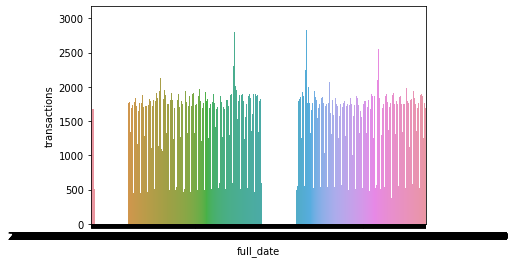

In [13]:
sns.barplot(data=piv_tr[piv_tr.store_nbr == 1], x="full_date", y="transactions")

Text(0.5, 0, 'date')

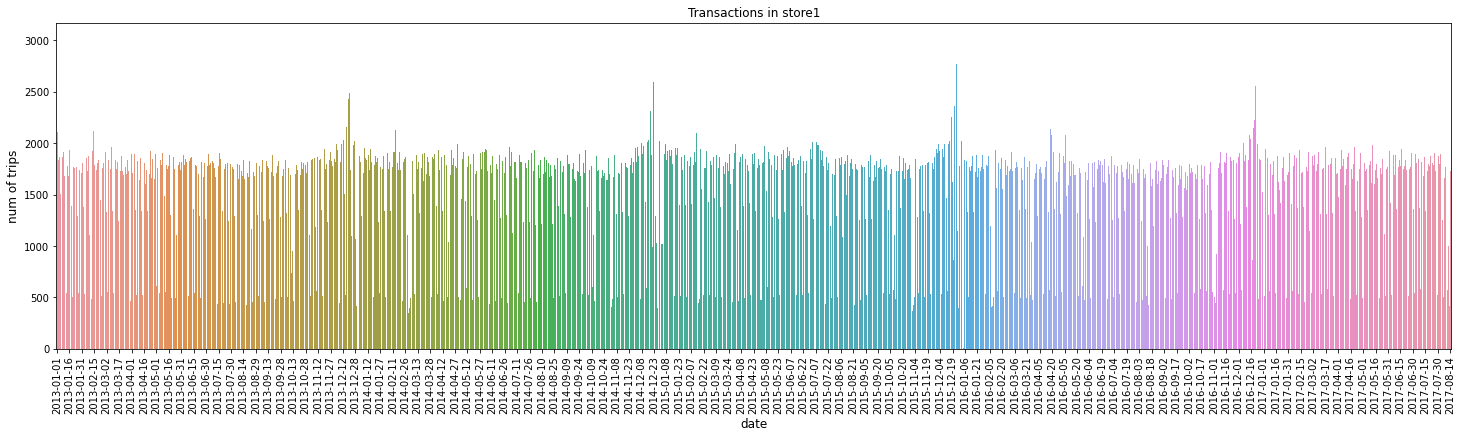

In [14]:
order = sorted(piv_tr.full_date.dt.date.value_counts().index)
fig, ax = plt.subplots(figsize=(25,6))
# dates = gr_transactions.full_date.dt.date
graph = sns.barplot(x='full_date',y ='transactions', data=piv_tr[piv_tr.store_nbr == 1], order=order)

new_ticks = [i.get_text() for i in graph.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 15), new_ticks[::15], rotation=90)

plt.title('Transactions in store1', fontsize=12)
plt.ylabel('num of trips', fontsize=12)
plt.xlabel('date', fontsize=12)

In [22]:
piv_tr

,store_nbr,full_date,transactions
0,1,2013-01-02,2111
1,1,2013-01-03,1833
2,1,2013-01-04,1863
3,1,2013-01-05,1509
4,1,2013-01-06,520
...,...,...,...
83483,54,2017-08-11,768
83484,54,2017-08-12,903
83485,54,2017-08-13,1054
83486,54,2017-08-14,818


In [16]:
[str(i)[:10] for i in piv_tr[piv_tr.store_nbr == 1].full_date]

['2013-01-02',
 '2013-01-03',
 '2013-01-04',
 '2013-01-05',
 '2013-01-06',
 '2013-01-07',
 '2013-01-08',
 '2013-01-09',
 '2013-01-10',
 '2013-01-11',
 '2013-01-12',
 '2013-01-13',
 '2013-01-14',
 '2013-01-15',
 '2013-01-16',
 '2013-01-17',
 '2013-01-18',
 '2013-01-19',
 '2013-01-20',
 '2013-01-21',
 '2013-01-22',
 '2013-01-23',
 '2013-01-24',
 '2013-01-25',
 '2013-01-26',
 '2013-01-27',
 '2013-01-28',
 '2013-01-29',
 '2013-01-30',
 '2013-01-31',
 '2013-02-01',
 '2013-02-02',
 '2013-02-03',
 '2013-02-04',
 '2013-02-05',
 '2013-02-06',
 '2013-02-07',
 '2013-02-08',
 '2013-02-09',
 '2013-02-10',
 '2013-02-11',
 '2013-02-12',
 '2013-02-13',
 '2013-02-14',
 '2013-02-15',
 '2013-02-16',
 '2013-02-17',
 '2013-02-18',
 '2013-02-19',
 '2013-02-20',
 '2013-02-21',
 '2013-02-22',
 '2013-02-23',
 '2013-02-24',
 '2013-02-25',
 '2013-02-26',
 '2013-02-27',
 '2013-02-28',
 '2013-03-01',
 '2013-03-02',
 '2013-03-03',
 '2013-03-04',
 '2013-03-05',
 '2013-03-06',
 '2013-03-07',
 '2013-03-08',
 '2013-03-

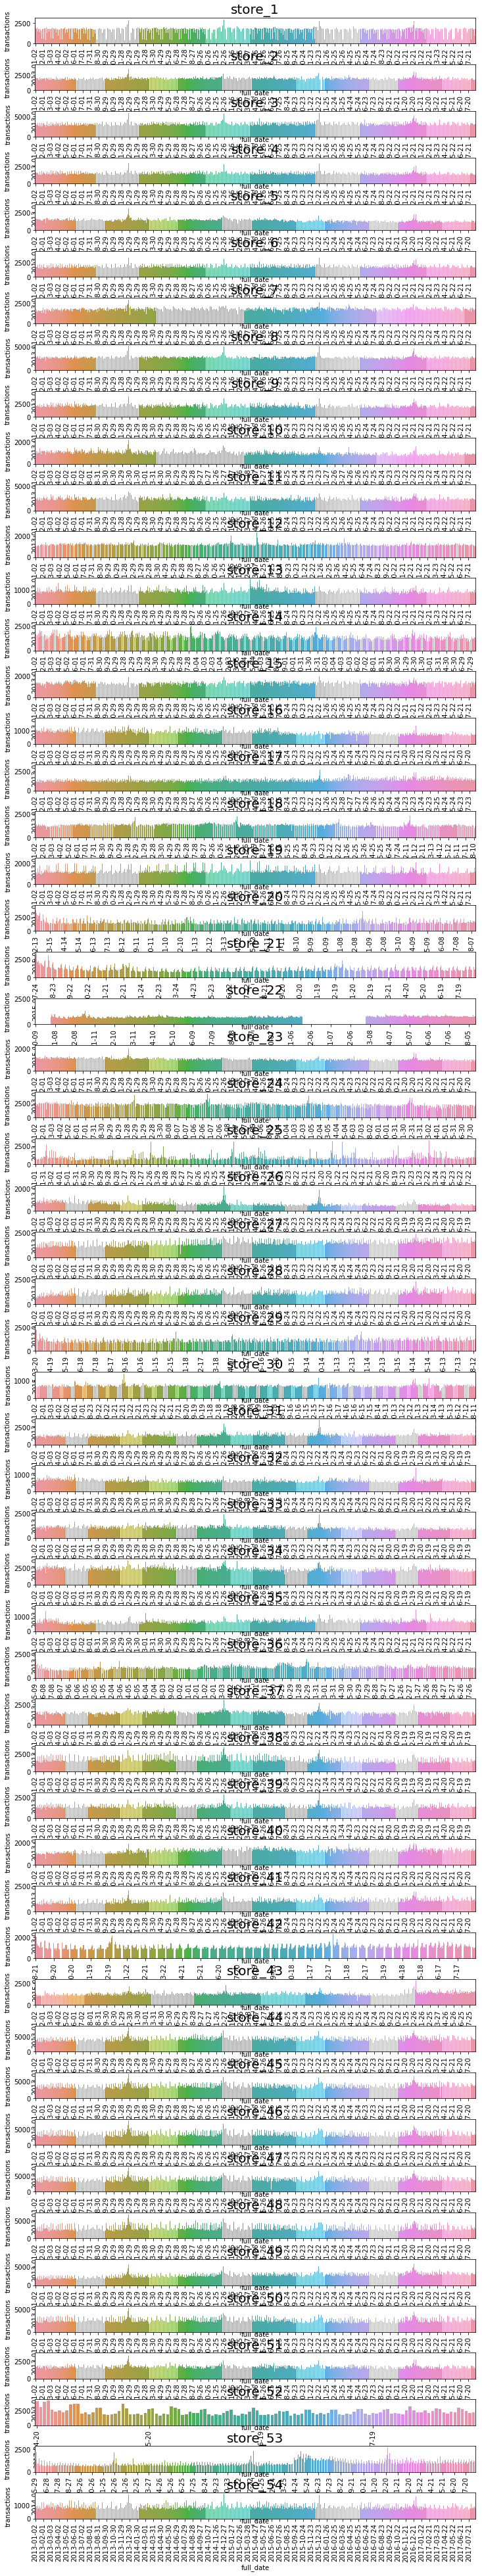

In [18]:
plt.figure(figsize=(12, 70))

for i in range(1, 55):
    plt.subplot(54, 1, i)
    sns.barplot(x='full_date', y='transactions', data=piv_tr[piv_tr.store_nbr == i])
    new_ticks = [str(i)[:10] for i in piv_tr[piv_tr.store_nbr == i].full_date]
    plt.xticks(range(0, len(new_ticks), 30), new_ticks[::30], rotation=90)

    plt.title('store_'+str(i), fontsize=20)

plt.subplots_adjust(hspace = 0.8) # space between subplots
plt.show()

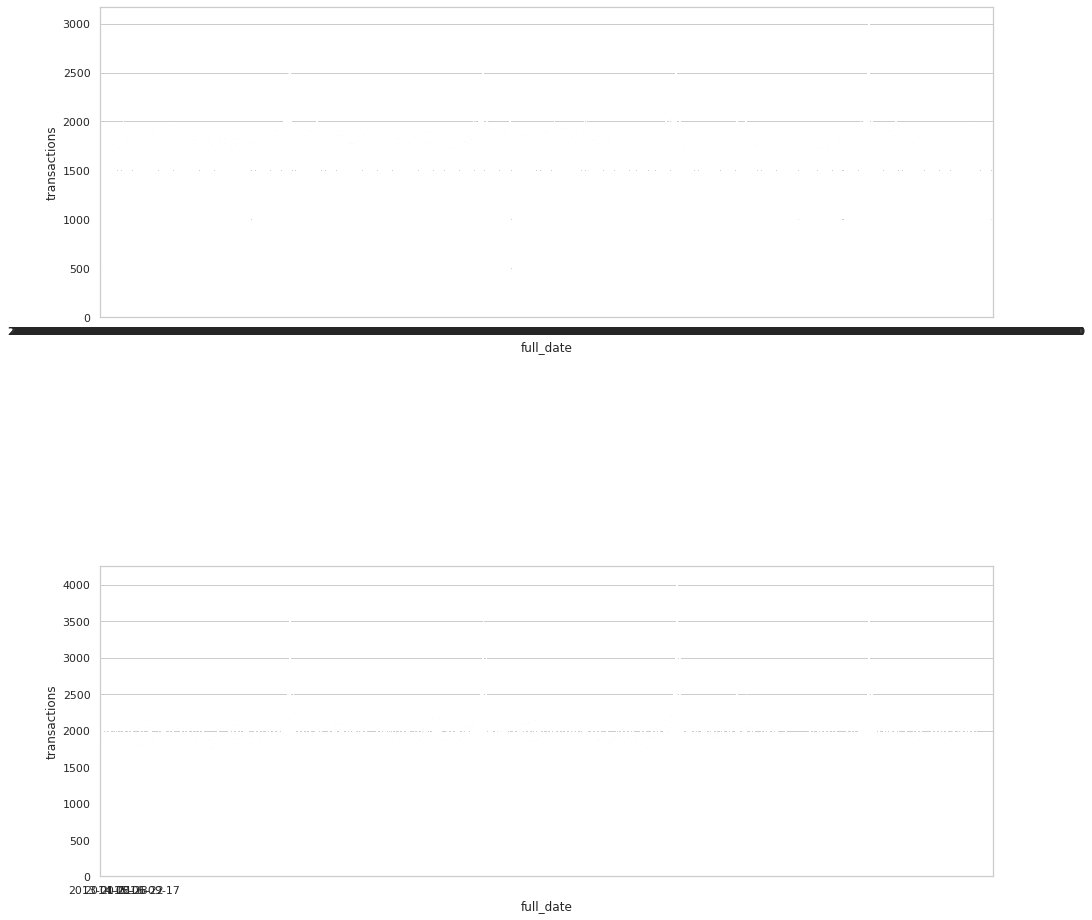

In [20]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 16))

plt.subplot(2, 1, 1)
sns.barplot(x='full_date', y='transactions', data=piv_tr[piv_tr.store_nbr == 1])

plt.subplot(2, 1, 2)
sns.barplot(y='transactions', x='full_date', data=piv_tr[piv_tr.store_nbr == 2])


new_ticks = [i.get_text() for i in graph.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 30), new_ticks[::30])
plt.subplots_adjust(hspace = 0.8)
plt.show()

<ipython-input-19-64be2adf608a>:5: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[0].set_xticks(range(0, len(new_ticks), 30), new_ticks[::30])
<ipython-input-19-64be2adf608a>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[1].set_xticks(range(0, len(new_ticks), 30), new_ticks[::30])


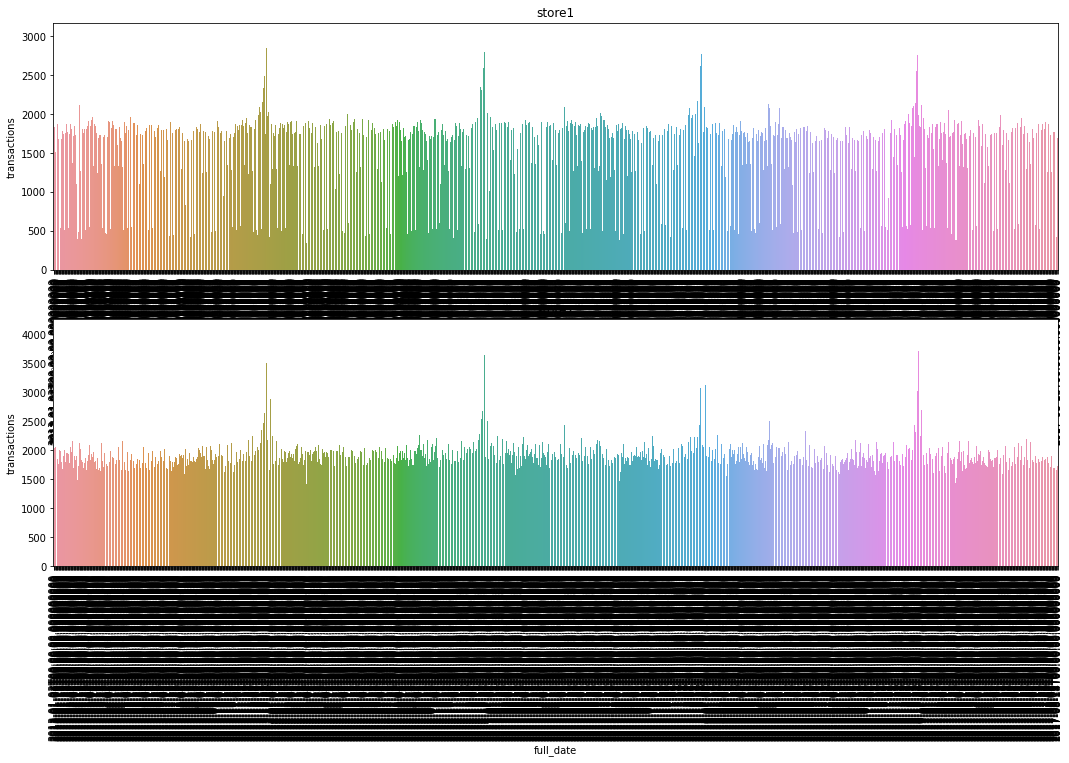

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

sns.barplot(ax=axes[0], data=piv_tr[piv_tr.store_nbr == 1], x='full_date', y='transactions')
new_ticks = [i.get_text() for i in graph.get_xticklabels()]
axes[0].set_xticks(range(0, len(new_ticks), 30), new_ticks[::30])
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title('store1')
sns.barplot(ax=axes[1], data=piv_tr[piv_tr.store_nbr == 2], x='full_date', y='transactions')
axes[1].set_title('store2')
axes[1].set_xticks(range(0, len(new_ticks), 30), new_ticks[::30])
axes[1].tick_params(axis='x', rotation=90)


In [11]:
order = sorted(piv_tr.full_date.dt.date.value_counts().index)

fig, axes = plt.subplots(54, 1, figsize=(20, 20), sharey=True)
for st in range(1, 55):
    print(st)
    axes[st-1].set_title('store' + str(st))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff146144280> (for post_execute):


KeyError: ignored

KeyError: ignored

<Figure size 1440x1440 with 54 Axes>

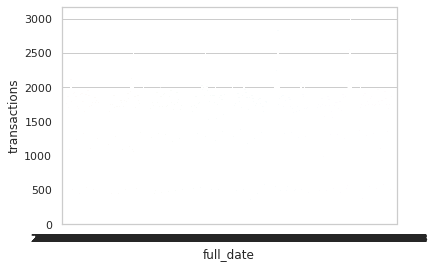

In [29]:
order = sorted(piv_tr.full_date.dt.date.value_counts().index)
plt.subplot(1, 1, 1)
sns.barplot(x='full_date',y ='transactions', data=piv_tr[piv_tr.store_nbr == 1], order=order)


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


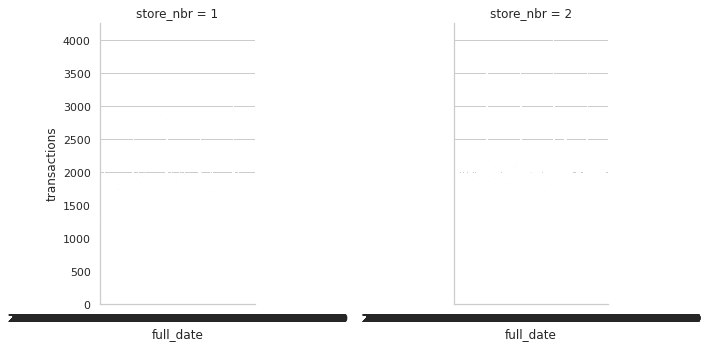

In [30]:
sns.factorplot("full_date", "transactions", col="store_nbr", data=piv_tr[piv_tr.store_nbr < 3], kind="bar")


In [ ]:
figure, axis = plt.subplots(5, 1, figsize=(12, 12))
for y in range(0, len(years)): 
    # df_name = 'df'+str(years[y])[2:]
    num = 0    
    rects2 = axis[y].bar(x - width/2, [years[y][(years[y]['week_num'] == i) & (years[y]['onpromotion'] == 0)].unit_sales.sum() for i in labels], color = "orange", width=width, label='Without promotion')
    rects4 = axis[y].bar(x + width/2, [years[y][(years[y]['week_num'] == i) & (years[y]['onpromotion'] == 1)].unit_sales.sum() for i in labels], color = "forestgreen", width=width, label='With promotion')
    num+=1
    axis[y].set_title("20" + str(13+y))

In [ ]:
plt.figure()
plt.tight_layout()
sns.set(rc={"figure.figsize":(8, 5)})
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
plt.gca().set(xlabel= i,ylabel='Frequency')
sns.boxplot(df[i], ax=ax_box , linewidth= 1.0)

1
2


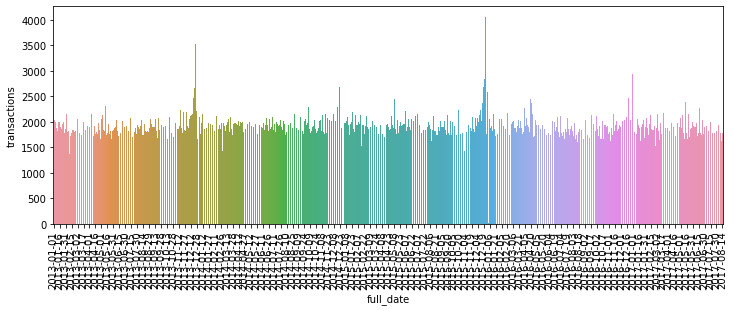

In [132]:
order = sorted(piv_tr.full_date.dt.date.value_counts().index)
# fig, ax = plt.subplots(figsize=(12,4))
for store in range (1, 3):
    print(store)
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 4)})
    f, (ax_box, ax_hist) = plt.subplots(1, sharex=True)
    plt.gca().set(xlabel= 'full_date', ylabel='transactions')
    graph = sns.barplot(x='full_date',y ='transactions', data=piv_tr[piv_tr.store_nbr == store], order=order)
    new_ticks = [i.get_text() for i in graph.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), 15), new_ticks[::15], rotation=90)

In [ ]:
    rects2 = axis[store].bar(x, [years[y][(years[y]['week_num'] == i) & (years[y]['onpromotion'] == 0)].unit_sales.sum() for i in labels], color = "orange", width=width, label='Without promotion')


#### analysis

In [ ]:
df_onprom_sales = grocery.groupby('onpromotion').unit_sales.sum().reset_index()
df_onprom_sales

,onpromotion,unit_sales
0,0,319239232.0
1,1,24222500.0


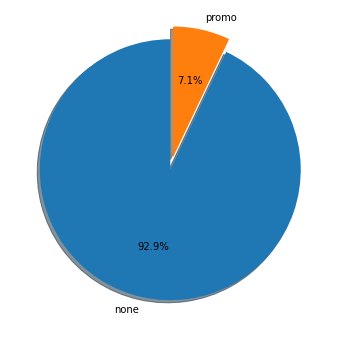

In [ ]:
explode = (0, 0.1)  
fig1, ax1 = plt.subplots(figsize = [6, 6])
ax1.pie(df_onprom_sales['unit_sales'], explode=explode, labels=['none','promo'], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

In [ ]:
df_store_sales = grocery.groupby('type').unit_sales.sum().reset_index()
df_store_sales

,type,unit_sales
0,A,105603272.0
1,B,53686072.0
2,C,64267120.0
3,D,99676584.0
4,E,20228684.0


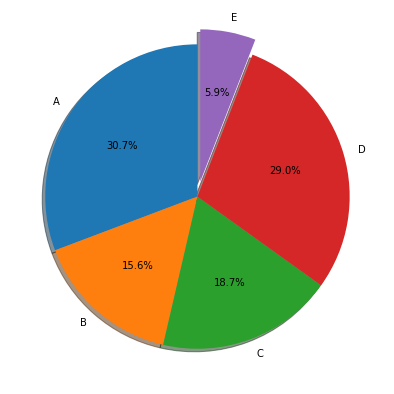

In [ ]:
explode = (0, 0, 0, 0, 0.1)  
fig1, ax1 = plt.subplots(figsize = [7, 7])
ax1.pie(df_store_sales['unit_sales'], explode=explode, labels = ['A', 'B', 'C', 'D', 'E'], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

In [ ]:
grocery.replace([1, 2, 3, 4, 5], ['A', 'B', 'C', 'D', 'E'])['type'].unique()

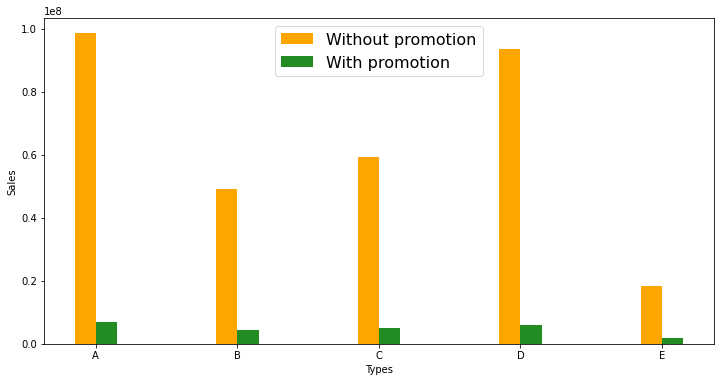

In [ ]:
labels = ['A', 'B', 'C', 'D', 'E']

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize = [12, 6])

rects2 = ax.bar(x - width/2, [grocery[(grocery['type'] == i) & (grocery['onpromotion'] == 0)].unit_sales.sum() for i in labels], color = 'orange', width=width, label='Without promotion')
rects4 = ax.bar(x + width/2, [grocery[(grocery['type'] == i) & (grocery['onpromotion'] == 1)].unit_sales.sum() for i in labels], color = 'forestgreen', width=width, label='With promotion')

plt.xticks(x, labels)
plt.xlabel("Types")
plt.ylabel("Sales")
plt.legend(fontsize = 16)


In [ ]:
grocery.isnull().sum().sort_values(ascending=False)


item_nbr       0
id             0
store_nbr      0
unit_sales     0
onpromotion    0
Year           0
Month          0
Day            0
type           0
dtype: int64

In [ ]:
grocery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45628066 entries, 0 to 45628065
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   item_nbr     uint32 
 1   id           uint32 
 2   store_nbr    uint8  
 3   unit_sales   float32
 4   onpromotion  int64  
 5   Year         uint16 
 6   Month        uint8  
 7   Day          uint8  
 8   type         object 
dtypes: float32(1), int64(1), object(1), uint16(1), uint32(2), uint8(3)
memory usage: 1.4+ GB


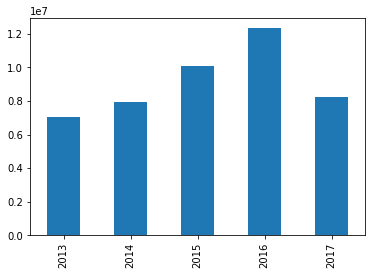

In [ ]:
grocery["Year"].value_counts(sort = False).plot.bar()

In [ ]:
int('2013')

2013

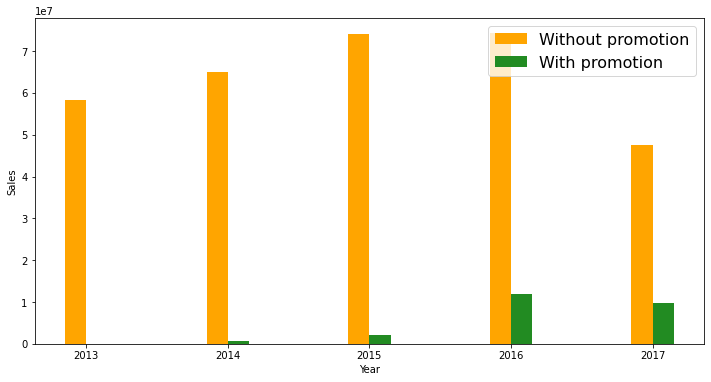

In [ ]:
labels = ['2013', '2014', '2015', '2016', '2017']

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize = [12, 6])

rects2 = ax.bar(x - width/2, [grocery[(grocery['Year'] == int(i)) & (grocery['onpromotion'] == 0)].unit_sales.sum() for i in labels], color = 'orange', width=width, label='Without promotion')
rects4 = ax.bar(x + width/2, [grocery[(grocery['Year'] == int(i)) & (grocery['onpromotion'] == 1)].unit_sales.sum() for i in labels], color = 'forestgreen', width=width, label='With promotion')

plt.xticks(x, labels)
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend(fontsize = 16)


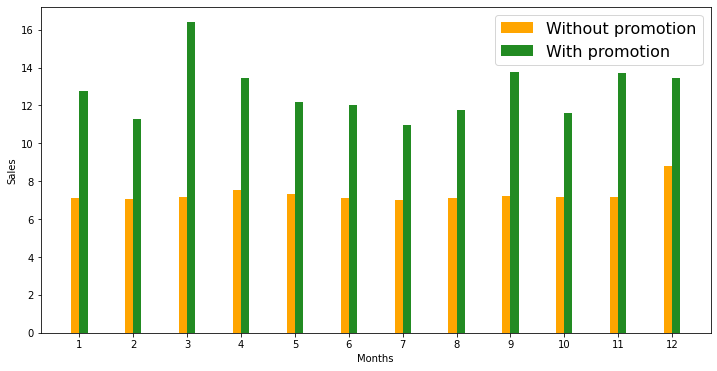

In [ ]:
labels = grocery.Month.unique()
labels.sort()

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize = [12, 6])

rects2 = ax.bar(x - width/2, [grocery[(grocery['Month'] == i) & (grocery['onpromotion'] == 0)].unit_sales.mean() for i in labels], color = 'orange', width=width, label='Without promotion')
rects4 = ax.bar(x + width/2, [grocery[(grocery['Month'] == i) & (grocery['onpromotion'] == 1)].unit_sales.mean() for i in labels], color = 'forestgreen', width=width, label='With promotion')

plt.xticks(x, labels)
plt.xlabel("Months")
plt.ylabel("Sales")
plt.legend(fontsize = 16)


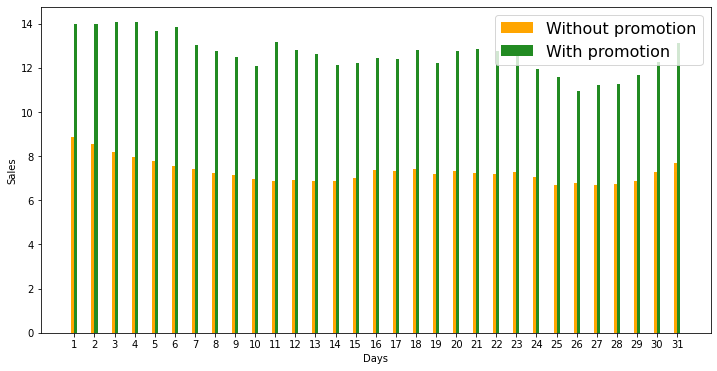

In [ ]:
 labels = grocery.Day.unique()
labels.sort()

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize = [12, 6])

rects2 = ax.bar(x - width/2, [grocery[(grocery['Day'] == i) & (grocery['onpromotion'] == 0)].unit_sales.mean() for i in labels], color = 'orange', width=width, label='Without promotion')
rects4 = ax.bar(x + width/2, [grocery[(grocery['Day'] == i) & (grocery['onpromotion'] == 1)].unit_sales.mean() for i in labels], color = 'forestgreen', width=width, label='With promotion')

plt.xticks(x, labels)
plt.xlabel("Days")
plt.ylabel("Sales")
plt.legend(fontsize = 16)


In [ ]:
stores_gr = grocery.store_nbr.unique()
# len(stores_gr)
stores_gr.sort()

In [ ]:
stores_gr

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54], dtype=uint8)

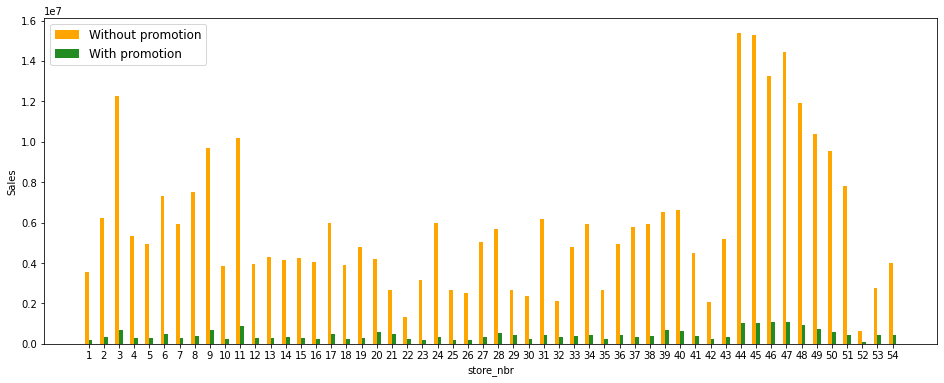

In [ ]:
labels = stores_gr

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = [16, 6])

rects2 = ax.bar(x - width/2, [grocery[(grocery['store_nbr'] == i) & (grocery['onpromotion'] == 0)].unit_sales.sum() for i in labels], color = 'orange', width=width, label='Without promotion')
rects4 = ax.bar(x + width/2, [grocery[(grocery['store_nbr'] == i) & (grocery['onpromotion'] == 1)].unit_sales.sum() for i in labels], color = 'forestgreen', width=width, label='With promotion')

plt.xticks(x, labels)
plt.xlabel("store_nbr")
plt.ylabel("Sales")
plt.legend(fontsize = 12)


####previous

In [ ]:
sale_day_store_level = train.groupby(['Year','Month','Day','store_nbr'])['unit_sales'].sum()
sale_day_item_level = train.groupby(['Year','Month','Day','item_nbr'])['unit_sales'].sum()

In [ ]:
def aggregate_level1(df):
    #day-store level
    sale_day_store_level=df.groupby(['Year','Month','Day','store_nbr'],as_index=False)['unit_sales'].agg(['sum','count'])
    #drop index and rename
    sale_day_store_level=sale_day_store_level.reset_index().rename(columns={'sum':'store_sales','count':'item_variety'})
    
    #day-item level  
    sale_day_item_level=df.groupby(['Year','Month','Day','item_nbr'],as_index=False)['unit_sales'].agg(['sum','count'])
    sale_day_item_level=sale_day_item_level.reset_index().rename(columns={'sum':'item_sales','count':'store_spread'})
    
    #store item level   
    sale_store_item_level=df.groupby(['Year','store_nbr','item_nbr'],as_index=False)['unit_sales'].agg(['sum','count'])
    sale_store_item_level=sale_store_item_level.reset_index().rename(columns={'sum':'item_sales','count':'entries'})

    return sale_day_store_level,sale_day_item_level,sale_store_item_level

In [ ]:
sale_day_store_level,sale_day_item_level,sale_store_item_level = aggregate_level1(train)

In [ ]:
sale_store_item_level = train.groupby(['Year','store_nbr','item_nbr', 'onpromotion'],as_index=False)['unit_sales'].agg(['sum','count'])
sale_store_item_level = sale_store_item_level.reset_index().rename(columns={'sum':'item_sales','count':'entries'})

In [ ]:
sale_store_item_level

,Year,store_nbr,item_nbr,onpromotion,item_sales,entries
0,2013,1,96995,0,248.0,151
1,2013,1,103520,0,775.0,256
2,2013,1,103665,0,1008.0,298
3,2013,1,105574,0,1622.0,333
4,2013,1,105575,0,3417.0,361
...,...,...,...,...,...,...
957775,2017,54,2113343,0,9.0,8
957776,2017,54,2113914,0,51.0,7
957777,2017,54,2113914,1,661.0,29
957778,2017,54,2116416,0,18.0,10


- Store-day level sale -- This variable indicates the sale of a particular store over time
- Store-day level count -- This variable gives an indication of the variaty/spread of the items sold
- Item-day level sale -- Sale of an item over time

In [ ]:
sale_day_store_level

,Year,Month,Day,store_nbr,store_sales,item_variety
0,2013,1,1,25,2511.618896,578
1,2013,1,2,1,7417.147949,1018
2,2013,1,2,2,10266.718750,1103
3,2013,1,2,3,24060.347656,1201
4,2013,1,2,4,10200.083984,1049
...,...,...,...,...,...,...
83601,2017,8,15,50,16879.121094,2381
83602,2017,8,15,51,20154.558594,2216
83603,2017,8,15,52,18600.046875,2380
83604,2017,8,15,53,8208.189453,1806


In [ ]:
sale_day_item_level

,Year,Month,Day,item_nbr,item_sales,store_spread
0,2013,1,1,103665,7.0,1
1,2013,1,1,105574,1.0,1
2,2013,1,1,105575,2.0,1
3,2013,1,1,108079,1.0,1
4,2013,1,1,108701,1.0,1
...,...,...,...,...,...,...
4655104,2017,8,15,2123863,3.0,3
4655105,2017,8,15,2124052,106.0,18
4655106,2017,8,15,2126842,3.0,2
4655107,2017,8,15,2126944,2.0,2


In [ ]:
sale_store_item_level

,Year,store_nbr,item_nbr,item_sales,entries
0,2013,1,96995,248.0,151
1,2013,1,103520,775.0,256
2,2013,1,103665,1008.0,298
3,2013,1,105574,1622.0,333
4,2013,1,105575,3417.0,361
...,...,...,...,...,...
640238,2017,54,2109909,25.0,9
640239,2017,54,2110456,18746.0,47
640240,2017,54,2113343,9.0,8
640241,2017,54,2113914,712.0,36


In [ ]:
out = '/content/drive/MyDrive/Marketing/favorita_data/'
# sale_day_store_level.to_csv(out + "sale_day_store_level.csv",index=False)
# sale_day_item_level.to_csv(out + "sale_day_item_level.csv",index=False)
# sale_store_item_level.to_csv(out + "sale_store_item_level.csv",index=False)

In [ ]:
sale_day_store_level = pd.read_csv(out + "sale_day_store_level.csv", index_col=False)
sale_day_item_level = pd.read_csv(out + "sale_day_item_level.csv", index_col=False)
sale_store_item_level = pd.read_csv(out + "sale_store_item_level.csv", index_col=False)

In [ ]:

# sale_day_store_level = sale_day_store_level.drop(columns = ['Unnamed: 0'])
# sale_day_item_level = sale_day_item_level.drop(columns = ['Unnamed: 0'])
# sale_store_item_level = sale_store_item_level.drop(columns = ['Unnamed: 0'])

In [ ]:
sale_day_store_level

,Year,Month,Day,store_nbr,store_sales,item_variety
0,2013,1,1,25,2511.619,578
1,2013,1,2,1,7417.148,1018
2,2013,1,2,2,10266.719,1103
3,2013,1,2,3,24060.348,1201
4,2013,1,2,4,10200.084,1049
...,...,...,...,...,...,...
83601,2017,8,15,50,16879.121,2381
83602,2017,8,15,51,20154.559,2216
83603,2017,8,15,52,18600.047,2380
83604,2017,8,15,53,8208.189,1806


In [ ]:
#Creating store level metrics
# sale_store_level = sale_day_store_level.groupby(['store_nbr'],as_index=False)['store_sales','item_variety'].agg(['sum'])
sale_store_level = sale_day_store_level.groupby('store_nbr')['store_sales','item_variety'].sum()
# Here the group by gives a multiindex , removing that
# sale_store_level.columns = sale_store_level.columns.droplevel(1)
sale_store_level=sale_store_level.reset_index()
sale_store_level.head()

<ipython-input-8-de081471ff16>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sale_store_level = sale_day_store_level.groupby('store_nbr')['store_sales','item_variety'].sum()


,store_nbr,store_sales,item_variety
0,1,1.414501e+07,2562153
1,2,2.155462e+07,2987840
2,3,5.048190e+07,3401264
3,4,1.890970e+07,2830554
4,5,1.559240e+07,2666691


In [ ]:
sale_item_level = sale_day_item_level.groupby(['item_nbr'],as_index=False)['item_sales'].sum()

# sale_item_level=sale_item_level.reset_index()
sale_item_level

,item_nbr,item_sales
0,96995,10143.0
1,99197,17870.0
2,103501,164753.0
3,103520,201117.0
4,103665,219669.0
...,...,...
4031,2123863,17.0
4032,2124052,5466.0
4033,2126842,19.0
4034,2126944,5.0


#### Plot stores

In [ ]:
color = sns.color_palette()

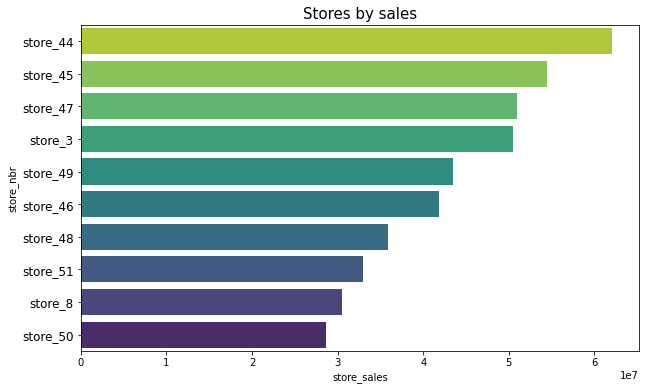

In [ ]:
temp = sale_day_store_level.groupby('store_nbr')['store_sales'].sum().reset_index().sort_values("store_sales", ascending = False)
temp['store_nbr'] = 'store_' + temp['store_nbr'].astype(str)

plt.figure(figsize = (10, 6))
sns.barplot(x = "store_sales", y = "store_nbr", data = temp[:10], palette = 'viridis_r')
plt.yticks(fontsize = 12)
plt.title("Stores by sales", fontsize = 15)
plt.show()

,item_nbr,item_sales,family,class,perishable
0,96995,10143.0,GROCERY I,1093,0
1,99197,17870.0,GROCERY I,1067,0
2,103501,164753.0,CLEANING,3008,0
3,103520,201117.0,GROCERY I,1028,0
4,103665,219669.0,BREAD/BAKERY,2712,1
...,...,...,...,...,...
4031,2123863,17.0,"LIQUOR,WINE,BEER",1318,0
4032,2124052,5466.0,"LIQUOR,WINE,BEER",1318,0
4033,2126842,19.0,GROCERY I,1030,0
4034,2126944,5.0,BEVERAGES,1142,0


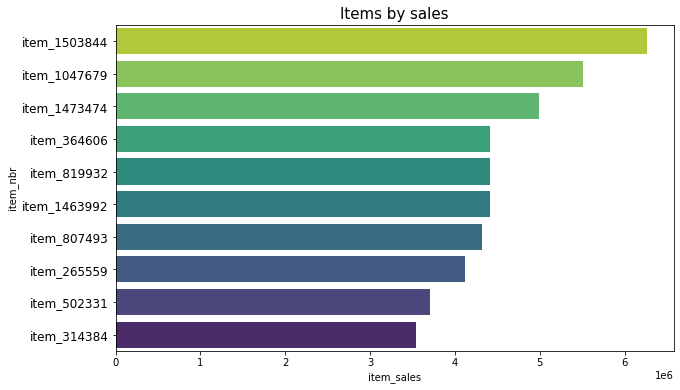

In [ ]:
temp = sale_item_level.sort_values("item_sales", ascending = False)
temp['item_nbr'] = 'item_' + temp['item_nbr'].astype(str)

plt.figure(figsize = (10, 6))
sns.barplot(x = "item_sales", y = "item_nbr", data = temp[:10], palette = 'viridis_r')
plt.yticks(fontsize = 12)
plt.title("Items by sales", fontsize = 15)
plt.show()

In [ ]:
temp = sale_item_level.merge(items, on="item_nbr")
temp

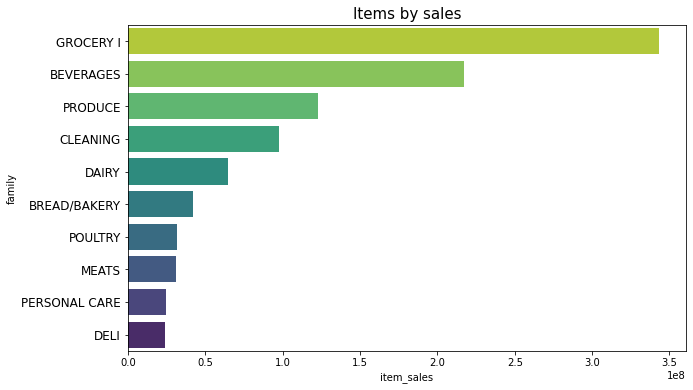

In [ ]:
temp_fam = temp.groupby('family')['item_sales'].sum().reset_index().sort_values("item_sales", ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(x = "item_sales", y = "family", data = temp_fam[:10], palette = 'viridis_r')
plt.yticks(fontsize = 12)
plt.title("Items by sales", fontsize = 15)
plt.show()

In [ ]:
store_items=pd.merge(sale_store_item_level,items,on='item_nbr')
store_items=pd.merge(store_items,stores,on='store_nbr')
store_items['item_sales']=store_items['item_sales']

top_family_by_type=store_items.groupby(['type','family'])['item_sales'].sum()
top_family_by_type=top_family_by_type.reset_index().sort_values(['type','item_sales'],ascending=[True,False])

#get top 5
top_family_by_type=top_family_by_type.groupby(['type']).head(5)

<Figure size 864x360 with 0 Axes>

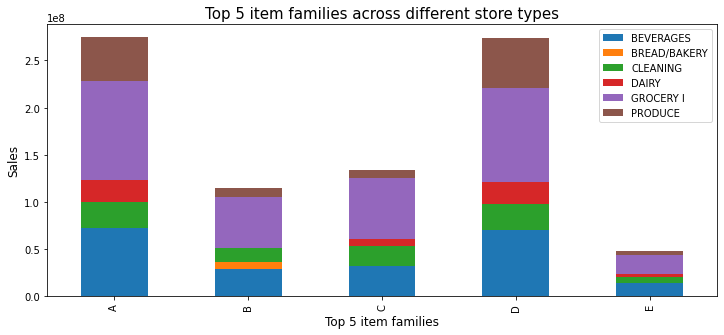

In [ ]:
plt.figure(figsize=(12,5))

x = top_family_by_type.pivot(index='type',columns='family')
sns.plot.bar(stacked = True,figsize=(12,5)palette = 'viridis_r')
y = x.columns.droplevel(0).values
#print(y)
plt.ylabel('Sales', fontsize=12)
plt.xlabel('Top 5 item families', fontsize=12)
plt.title('Top 5 item families across different store types', fontsize=15)
plt.xticks(rotation='vertical')
plt.legend(y)
plt.show()

#### Plot train df

In [ ]:
# fig, ax = plt.subplots(figsize=(20,12))
# sns_heatmap = sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           uint32 
 1   store_nbr    uint8  
 2   item_nbr     uint32 
 3   unit_sales   float32
 4   onpromotion  int8   
 5   Year         uint16 
 6   Month        uint8  
 7   Day          uint8  
dtypes: float32(1), int8(1), uint16(1), uint32(2), uint8(3)
memory usage: 2.1 GB


In [ ]:
train.head()

,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day
0,25,103665,7.0,0,2013,1,1
1,25,105574,1.0,0,2013,1,1
2,25,105575,2.0,0,2013,1,1
3,25,108079,1.0,0,2013,1,1
4,25,108701,1.0,0,2013,1,1


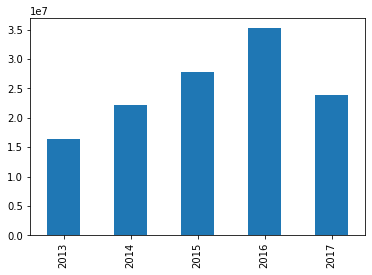

In [ ]:
train["Year"].value_counts(sort = False).plot.bar()

In [ ]:
store_items.reset_index()

,index,Unnamed: 0,Year,store_nbr,item_nbr,item_sales,entries,family,class,perishable,city,state,type,cluster
0,0,0,2013,1,96995,248.000,151,GROCERY I,1093,0,Quito,Pichincha,D,13
1,1,70960,2014,1,96995,17.000,11,GROCERY I,1093,0,Quito,Pichincha,D,13
2,2,472728,2017,1,96995,36.000,25,GROCERY I,1093,0,Quito,Pichincha,D,13
3,3,1,2013,1,103520,775.000,256,GROCERY I,1028,0,Quito,Pichincha,D,13
4,4,70962,2014,1,103520,842.000,265,GROCERY I,1028,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640238,640238,538308,2017,22,2060793,1889.000,90,BEVERAGES,1142,0,Puyo,Pastaza,C,7
640239,640239,538313,2017,22,2061214,1818.000,88,BEVERAGES,1142,0,Puyo,Pastaza,C,7
640240,640240,538341,2017,22,2089036,38.000,15,GROCERY I,1034,0,Puyo,Pastaza,C,7
640241,640241,538225,2017,22,2033554,947.098,134,PRODUCE,2012,1,Puyo,Pastaza,C,7


In [ ]:
# monthly = train[['id', 'Month']]
monthly = train.groupby("Month")["id"].nunique()

In [ ]:
monthly.head()

Month
1    10861741
2     9912519
3    11435376
4    10686341
5    11271078
Name: id, dtype: int64

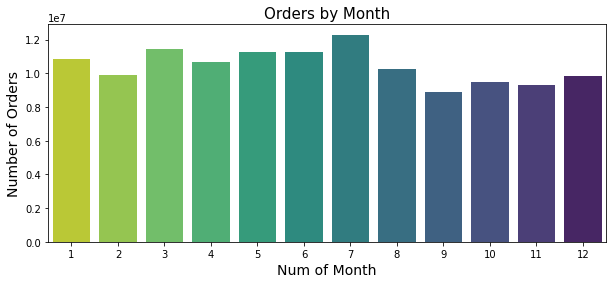

In [ ]:
orders_byMonth = monthly.reset_index().sort_values('id', ascending = False)
plt.figure(figsize = (10, 4))
sns.barplot(x = 'Month', y = 'id', data = orders_byMonth, palette = 'viridis_r')
plt.xlabel("Num of Month", fontsize = 14)
plt.ylabel("Number of Orders", fontsize = 14)
plt.title("Orders by Month", fontsize = 15)
plt.show()

In [ ]:
train.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day
0,0,25,103665,7.0,0,2013,1,1
1,1,25,105574,1.0,0,2013,1,1
2,2,25,105575,2.0,0,2013,1,1
3,3,25,108079,1.0,0,2013,1,1
4,4,25,108701,1.0,0,2013,1,1


In [ ]:
train.describe()

,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day
count,1.254970e+08,1.254970e+08,1.254970e+08,1.254970e+08,1.254970e+08,1.254970e+08,1.254970e+08
mean,2.746458e+01,9.727692e+05,8.554856e+00,6.223750e-02,2.015223e+03,6.334971e+00,1.560188e+01
std,1.633051e+01,5.205336e+05,2.360515e+01,2.415864e-01,1.299140e+00,3.392866e+00,8.816411e+00
min,1.000000e+00,9.699500e+04,-1.537200e+04,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00
25%,1.200000e+01,5.223830e+05,2.000000e+00,0.000000e+00,2.014000e+03,3.000000e+00,8.000000e+00
50%,2.800000e+01,9.595000e+05,4.000000e+00,0.000000e+00,2.015000e+03,6.000000e+00,1.500000e+01
75%,4.300000e+01,1.354380e+06,9.000000e+00,0.000000e+00,2.016000e+03,9.000000e+00,2.300000e+01
max,5.400000e+01,2.127114e+06,8.944000e+04,1.000000e+00,2.017000e+03,1.200000e+01,3.100000e+01


In [ ]:
stores_t = stores[['type', 'store_nbr']]
stores_t

,type,store_nbr
0,D,1
1,D,2
2,D,3
3,D,4
4,D,5
5,D,6
6,D,7
7,D,8
8,B,9
9,C,10


In [ ]:
sales_st = train[['store_nbr', 'unit_sales']]
sales_st = sales_st.groupby('store_nbr').sum()
sales_st

In [ ]:
sales_st.reset_index()

In [ ]:
sales_type = sales_st.merge(stores_t, on='store_nbr', how='left')
sales_type

,store_nbr,unit_sales,type
0,1,14145012.00,D
1,2,21554618.00,D
2,3,50481900.00,D
3,4,18909698.00,D
4,5,15592405.00,D
5,6,25183676.00,D
6,7,26952020.00,D
7,8,30491336.00,D
8,9,26409398.00,B
9,10,9613906.00,C


In [ ]:
sales_type.to_csv(out + "sales_type.csv")


In [ ]:
del(sales_st)

In [ ]:
df_store_sales

,type,unit_sales
0,A,353043808.0
1,B,145248256.0
2,C,164434448.0
3,D,351063328.0
4,E,59820424.0


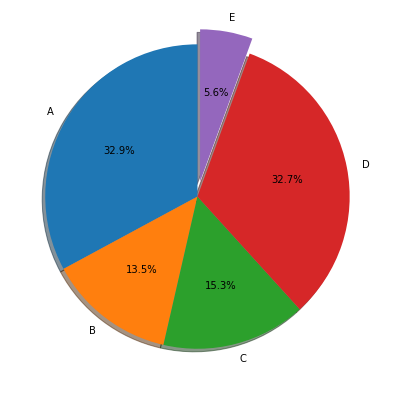

In [ ]:
df_store_sales = sales_type.groupby('type').unit_sales.sum().reset_index()
explode = (0, 0, 0, 0, 0.1)  
fig1, ax1 = plt.subplots(figsize = [7, 7])
ax1.pie(df_store_sales['unit_sales'], explode=explode, labels = ['A', 'B', 'C', 'D', 'E'], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

#### promo data

In [ ]:
df_onprom_sales = train.groupby('onpromotion').unit_sales.sum().reset_index()
df_onprom_sales

,onpromotion,unit_sales
0,0,968427200.0
1,1,105183040.0


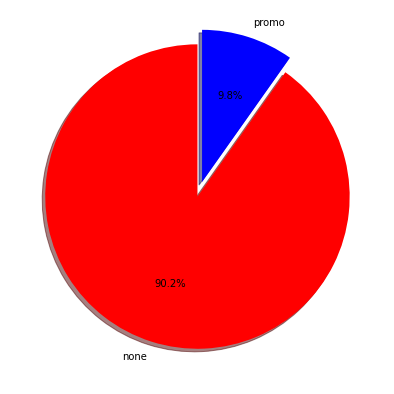

In [ ]:
colors = ['red', 'blue']
explode = (0, 0.1)  

fig1, ax1 = plt.subplots(figsize = [7, 7])
ax1.pie(df_onprom_sales['unit_sales'], explode=explode, labels=['none','promo'], autopct='%1.1f%%', colors = colors,
        shadow=True, startangle=90)
plt.show()

In [ ]:
items

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1
...,...,...,...,...
4095,2132318,GROCERY I,1002,0
4096,2132945,GROCERY I,1026,0
4097,2132957,GROCERY I,1068,0
4098,2134058,BEVERAGES,1124,0


In [ ]:
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [ ]:
stores_t = stores[['type', 'store_nbr']]


In [ ]:
sale_store_item_level

,Year,store_nbr,item_nbr,onpromotion,item_sales,entries
0,2013,1,96995,0,248.0,151
1,2013,1,103520,0,775.0,256
2,2013,1,103665,0,1008.0,298
3,2013,1,105574,0,1622.0,333
4,2013,1,105575,0,3417.0,361
...,...,...,...,...,...,...
957775,2017,54,2113343,0,9.0,8
957776,2017,54,2113914,0,51.0,7
957777,2017,54,2113914,1,661.0,29
957778,2017,54,2116416,0,18.0,10


In [ ]:
items

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1
...,...,...,...,...
4095,2132318,GROCERY I,1002,0
4096,2132945,GROCERY I,1026,0
4097,2132957,GROCERY I,1068,0
4098,2134058,BEVERAGES,1124,0


In [ ]:
promo_items_stores = sale_store_item_level.merge(items, on='item_nbr', how='left')


In [ ]:
promo_items_stores

,Year,store_nbr,item_nbr,onpromotion,item_sales,entries,family,class,perishable
0,2013,1,96995,0,248.0,151,GROCERY I,1093,0
1,2013,1,103520,0,775.0,256,GROCERY I,1028,0
2,2013,1,103665,0,1008.0,298,BREAD/BAKERY,2712,1
3,2013,1,105574,0,1622.0,333,GROCERY I,1045,0
4,2013,1,105575,0,3417.0,361,GROCERY I,1045,0
...,...,...,...,...,...,...,...,...,...
957775,2017,54,2113343,0,9.0,8,BEVERAGES,1114,0
957776,2017,54,2113914,0,51.0,7,CLEANING,3040,0
957777,2017,54,2113914,1,661.0,29,CLEANING,3040,0
957778,2017,54,2116416,0,18.0,10,GROCERY I,1060,0


In [ ]:
promo_items_stores.to_csv(out + "promo_items_stores.csv",index=False)


In [ ]:
pr_st = promo_items_stores.groupby('onpromotion').perishable.count().reset_index()

,onpromotion,perishable
0,0,639058
1,1,318722


In [ ]:
x = ['perishable', 'non_perishable']
y1 = [10, 20, 10, 30]
y2 = [20, 25, 15, 25]
 
# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.show()

In [ ]:
train.head()

,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day
0,25,103665,7.0,0,2013,1,1
1,25,105574,1.0,0,2013,1,1
2,25,105575,2.0,0,2013,1,1
3,25,108079,1.0,0,2013,1,1
4,25,108701,1.0,0,2013,1,1


In [ ]:
promo_it = train[['i']]

In [ ]:
df_per_prom = train
newone = df_per_prom.groupby('onpromotion').perishable.sum().reset_index()


In [ ]:
plt.figure(figsize=(12,5))

x = top_family_by_type.pivot(index='type',columns='family')
sns.plot.bar(stacked = True,figsize=(12,5)palette = 'viridis_r')
y = x.columns.droplevel(0).values
#print(y)
plt.ylabel('Sales', fontsize=12)
plt.xlabel('Top 5 item families', fontsize=12)
plt.title('Top 5 item families across different store types', fontsize=15)
plt.xticks(rotation='vertical')
plt.legend(y)
plt.show()

In [ ]:
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = [30, 15], dpi = 500)

rects2 = ax.bar(x - width/2, [df[(df['family'] == i) & (df['onpromotion'] == 0)].unit_sales.sum() for i in lst], color = 'salmon', width=width, label='Without promotion')
rects4 = ax.bar(x + width/2, [df[(df['family'] == i) & (df['onpromotion'] == 1)].unit_sales.sum() for i in lst], color = 'cornflowerblue', width=width, label='With promotion')


ax.set_xticks(x, labels) 
ax.tick_params(axis='both', which='major')
ax.legend(fontsize = 50)

fig.tight_layout()